# Introduction

This notebook analyzes the output of Anchore, Clair and Vuls on BIDS app and Boutiques container images. The data is structured as follows:

* `images.csv`: list of tested images, with distribution, version, and number of packages.
* `Data/<scanner>`: output of scanner <scanner>, contains subdirectories for BIDS and Boutiques images, with one output file for each container image.
    
   TODO: update and minification and both
    
The remainder of this notebook parses this data and plots the figures used in the paper.

# Parsing of result files

First, we read the list of container images, distributions and number of packages.

In [1]:
with open('./images.csv', 'r') as f:
    lines = f.readlines()
images = { l.split(',')[0]: (l.split(',')[1], l.split(',')[2].strip()) for l in lines[1:]}

This dictionary will be reused throughout the notebook:

In [2]:
images
# image: (distro, n_packages)

{'gkiar/onevoxel:v0.3.0rc2': ('alpine:3.7.1', '71'),
 'bids/rshrf:1.0.1': ('alpine:3.8.4', '35'),
 'gkiar/mask2boundary:v0.1.0': ('alpine:3.9.0', '61'),
 'bids/broccoli:v1.0.0': ('centos:6', '253'),
 'mcin/docker-fsl:latest': ('centos:7', '145'),
 'bids/nipypelines:0.3.0': ('debian:8', '157'),
 'bids/baracus': ('ubuntu:14.04', '218'),
 'bids/rs_signal_extract:0.1': ('ubuntu:16.04', '241'),
 'bids/antscorticalthickness:v2.2.0-1': ('ubuntu:17.04', '291'),
 'bids/afni_proc': ('ubuntu:17.10', '277'),
 'mcin/ica-aroma:latest': ('centos:7', '159'),
 'bids/magetbrain': ('ubuntu:18.04', '167'),
 'mcin/qeeg:latest': ('centos:7', '171'),
 'bt5e/ants:latest': ('centos:7', '188'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7-fslbuild-centos5-latest': ('centos:7',
  '240'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7.freesurferbuild-centos4-latest': ('centos:7',
  '254'),
 'bids/brainiak-srm': ('ubuntu:16.04', '258'),
 'gkiar/dwipreproc_fsl-5.0.11_minified': ('ubuntu:16.04', '269'),
 'bids/m

In [3]:
len(images)

38

We will analyze the scanning results of these 38 images. TODO: how about Singularity images?

## Anchore

Here we parse the vulnerabilities detected by Anchore, and summarize them in a DataFrame:

In [4]:
import os.path as op
data_dir = './Data/Anchore'

anchore_files = {}

# Find vulnerability file by image name
for d in images:
    
    prefix, image = d.split('/')
    
    # Check if image is from BIDS or Boutiques (heuristic)
    if prefix.upper() != 'BIDS' and prefix != 'poldracklab':
        prefix = 'Boutiques'
    else:
        prefix = 'BIDS'
    if ':' in image:
        image_name, version = image.split(':')
    else:
        image_name = image
        version = 'latest'
    
    # Handle ndmg manually
    if d == 'bids/ndmg:v0.1.0':
        prefix = 'Boutiques'
        image_name = 'ndmg'
        version = 'v0.1.0'
    
    # Handle fmriprep manually
    if d == 'poldracklab/fmriprep:1.2.3':
        prefix = 'Boutiques'
        image_name = 'fmriprep'
        version = '1.2.3'
    
    # Handle hcp-prefreesurfer manually
    if image_name == 'hcp-prefreesurfer':
        if version == 'exec-centos7-fslbuild-centos5-latest':
            image_name = 'hcp-prefreesurfer1'
        if version == 'exec-centos7.freesurferbuild-centos4-latest':
            image_name = 'hcp-prefreesurfer2'
    
    file_name = op.join(data_dir, prefix, image_name) + '.csv'
    if not op.isfile(file_name):
        print(f'File not found: {file_name}')

    anchore_files[d] = (file_name, images[d][0], images[d][1])

In [5]:
anchore_files['poldracklab/fmriprep:1.2.3']
# Each entry in anchore_files is a triple: (file_name, container_image, n_packages)

('./Data/Anchore/Boutiques/fmriprep.csv', 'ubuntu:16.04', '441')

Let's also read the number of vulnerabilities after minification and update: TODO: Put raw Anchore outputs should be in BIDS and Boutiques directories.

In [6]:
    # Get total vulnerabilities after minification
    with open('./Results_after_minification.csv', 'r') as f:
        lines = f.readlines()

    minifications = [ line.split(',') for line in lines[1:]]
    def get_after_minification(packages, vulnerabilities):
        for l in minifications:
            # TODO: check discrepancy in the number of vulnerabilities in Results_after_update2.csv
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[2].strip())

In [7]:
    # Get total vulnerabilities after update
    with open('./Results_after_update2.csv', 'r') as f:
        lines = f.readlines()

    updates = [ line.split(',') for line in lines[1:]]
    def get_after_updates(packages, vulnerabilities):
        for l in updates:
            # TODO: check discrepancy in the number of vulnerabilities in Results_after_update2.csv
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[2].strip())

In [8]:
    # Get total vulnerabilities after update AND minification
    with open('./Results_after_updateANDminification.csv', 'r') as f:
        lines = f.readlines()

    boths = [ line.split(',') for line in lines[1:]]
    def get_after_both(packages, vulnerabilities):
        for l in boths:
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[1].strip())

We're now ready to build our summary DataFrame:

In [9]:
import pandas as pd
import shlex

# Colors that will be used to represent distributions in Figures
# Keep this here as it's used in various functions
distro_colors = {
        'ubuntu': 'xkcd:orangered',
        'debian': 'xkcd:teal',
        'centos': 'xkcd:blue',
        'alpine': 'xkcd:lightblue'
}
    
def get_summary(dist_files, get_n_unique_vul, severity = True, update_and_minif=True):
    '''
    Parameters
    ----------
    dist_files : dictionary associating scanner output files with image names and versions. Example: anchore_files.
    get_n_unique_vul : a function with two parameters, 'severity' and 'lines', where 'severity' is a vulnerability severity
                       (ex: 'High'), and 'lines' is the list of lines found in a scanner output. Returns the number of 
                       vulnerabilities of severity 'severity' in 'lines'.
    severity : True if summary has to include vulnerability counts by severity (Anchore and Clair only)
    update_and_minif : True if summary has to include vulnerability counts after update and minification (Anchore only)

    Returns
    -------
    summary : a data frame with vulnerability counts by image
    '''
        
    # Columns of the dataframe
    df_columns = ['Abbrv', 'Image', 'Distribution', 'Version', 'Color', # image and parameters
                  'Negligible', 'Low', 'Medium', 'High', 'Critical', # vulnerabilities by severity
                  'Total', 'Total_after_update', 'Total_after_minification', 'Total_after_both', 'File'] # total vulnerabilities
        
    summary = pd.DataFrame(columns=df_columns)
    
    for i, image in enumerate(dist_files):
        
        # Read scanner output
        filename = dist_files[image][0]
        with open(filename, 'r') as f:
            lines = f.readlines()
        
        if severity:
            negligible = get_n_unique_vul('Negligible', lines)
            low = get_n_unique_vul('Low', lines)
            medium = get_n_unique_vul('Medium', lines)
            high = get_n_unique_vul('High', lines)
            critical = get_n_unique_vul('Critical', lines)
            total = negligible + low + medium + high + critical
        else:
            negligible = None
            low = None
            medium = None
            high = None
            critical = None
            total = get_n_unique_vul('All', lines)
        
        # Total number of packages
        packages = int(dist_files[image][2])
        
        # Define abbreviations to be used in figures
        abbrv = image.split('/')[1]
        if ':' in abbrv:
            abbrv = abbrv.split(':')[0]
        collisions = ['ndmg', 'hcp-prefreesurfer', 'fmriprep']
        if abbrv in collisions:
            abbrv += str(i % 2)
        ascii = 65 + i
        if ascii > 90:
            ascii += 6
        abbrv = chr(ascii) + " "
        
        # Get vulnerabilities after update and minification
        after_update = None
        after_minification = None
        after_both = None
        if update_and_minif:
            after_update = get_after_updates(packages, total)
            after_minification = get_after_minification(packages, total)
            after_both = get_after_both(packages, total)
    
            if image == 'bids/afni_proc': # npackage-based calculations doesn't work here
                after_update = None
                after_minification = None
                both = None
            
        version = images[image][0].split(':')[1]
        distribution = images[image][0].split(':')[0]
        summary = summary.append({
            'Image': image,
            'Abbrv': abbrv,
            'Distribution': distribution,
            'Version': version,
            'Color': distro_colors[distribution],
            'Packages': packages,
            'Negligible': negligible,
            'Low': low,
            'Medium': medium,
            'High': high,
            'Critical': critical,
            'Total': total,
            'Total_after_update': after_update,
            'Total_after_minification': after_minification,
            'Total_after_both': after_both,
            'File': filename
        }, ignore_index=True)
    summary = summary.sort_values('Total', ascending=False)
    return summary

We can now call this function on Anchore's output:

In [10]:
def get_n_unique_vul_anchore(status, lines):
    lines = [ shlex.split(line) for line in lines ][1:]
    cves = [x[0] for x in lines if x[2] == status]
    return len(set(cves))

anchore_summary = get_summary(anchore_files, get_n_unique_vul_anchore)
anchore_summary

Abbrv                                              Image Distribution  \
36    k                                 bids/hyperalignment       ubuntu   
37    l                                           bids/niak       ubuntu   
33    h                    bids/fibredensityandcrosssection       ubuntu   
31    f                                    bids/ndmg:v0.1.0       ubuntu   
32    g                                           bids/ndmg       ubuntu   
35    j                                 bids/oppni:v0.7.0-1       ubuntu   
16    Q                                   bids/brainiak-srm       ubuntu   
30    e                               bids/tracula:v6.0.0-4       ubuntu   
7     H                          bids/rs_signal_extract:0.1       ubuntu   
29    d                                        bids/example       ubuntu   
34    i                                bids/cpac:v1.0.1a_22       ubuntu   
18    S                             bids/mindboggle:0.0.4-1       debian   
5     F                              bids/nipypelines:0.3.0       debian   
26    a                          poldracklab/fmriprep:1.2.3       ubuntu   
27    b                       poldracklab/fmriprep:unstable       ubuntu   
25    Z                        bids/hcppipelines:v3.17.0-18       debian   
28    c                                 bids/dparsf:v4.3.12       ubuntu   
24    Y                            poldracklab/mriqc:0.15.0       ubuntu   
17    R                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
20    U                                     bids/freesurfer       ubuntu   
8     I                 bids/antscorticalthickness:v2.2.0-1       ubuntu   
21    V                             bids/mrtrix3_connectome       ubuntu   
22    W                                            bids/spm       ubuntu   
23    X                                      bids/aa:v0.2.0       ubuntu   
6     G                                        bids/baracus       ubuntu   
13    N                                    bt5e/ants:latest       centos   
11    L                                     bids/magetbrain       ubuntu   
3     D                                bids/broccoli:v1.0.0       centos   
10    K                               mcin/ica-aroma:latest       centos   
4     E                              mcin/docker-fsl:latest       centos   
15    P   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
14    O   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
9     J                                      bids/afni_proc       ubuntu   
19    T                              camarasu/creaphase:0.3       centos   
12    M                                    mcin/qeeg:latest       centos   
2     C                          gkiar/mask2boundary:v0.1.0       alpine   
1     B                                    bids/rshrf:1.0.1       alpine   
0     A                            gkiar/onevoxel:v0.3.0rc2       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
36   16.04  xkcd:orangered        100  594    971   50        1  1716   
37   16.04  xkcd:orangered        106  557    783   35        1  1482   
33   14.04  xkcd:orangered         79  427    545   34        1  1086   
31   14.04  xkcd:orangered         79  387    448   20        0   934   
32   14.04  xkcd:orangered         79  387    448   20        0   934   
35   14.04  xkcd:orangered         76  371    438   27        1   913   
16   16.04  xkcd:orangered         54  365    431   46        1   897   
30   14.04  xkcd:orangered         76  360    415   22        1   874   
7    16.04  xkcd:orangered         61  378    383   44        1   867   
29   14.04  xkcd:orangered         76  358    385   19        0   838   
34   16.04  xkcd:orangered         56  348    276   18        0   698   
18       8       xkcd:teal        165   61    279  159        0   664   
5        8       xkcd:teal        130   72    266  162        0   630   
26   16.04  xkcd

In [11]:
# Sanity check
len(anchore_summary)

38

In [12]:
# Average number of vulnerabilities per image
anchore_summary['Total'].mean()

467.8421052631579

In [13]:
# Median number of vulnerabilities per image
anchore_summary['Total'].median()

372.0

## Ideas about attacks

To have a better idea of the type of attacks that could exploit these vulnerabilities, we can list the critical vulnerabilities:

In [14]:
# List unique critical CVEs
import shlex
file_names = [anchore_files[image][0] for image in images]
critical = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        lines = f.readlines()
    lines = [ shlex.split(line) for line in lines ][1:]
    critical += [(l[0], l[4]) for l in lines if l[2] == 'Critical']
critical = set(critical)
for c in critical:
    print(c)

('RHSA-2015:1981', 'https://access.redhat.com/errata/RHSA-2015:1981')
('RHSA-2016:0370', 'https://access.redhat.com/errata/RHSA-2016:0370')
('RHSA-2017:1100', 'https://access.redhat.com/errata/RHSA-2017:1100')
('CVE-2017-5754', 'http://people.ubuntu.com/~ubuntu-security/cve/CVE-2017-5754')
('RHSA-2016:0176', 'https://access.redhat.com/errata/RHSA-2016:0176')


These links give interesting insights on how containers could be attacked when deployed on HPC clusters.

## Clair

To get the summary of vulnerabilities reported by Clair, we generate the output file names, and call function get_summary to generate a data frame in the same format as for Anchore:

In [15]:
import os 

clair_files = {}
for image in images:
    clair_files[image] = (anchore_files[image][0].replace('Anchore', 'Clair').replace('csv', 'txt'),
                          anchore_files[image][1],
                          anchore_files[image][2] )

for f in clair_files:
    if not os.path.isfile(clair_files[f][0]):
        print(f'Missing file: {clair_files[f][0]}')

In [16]:
def get_n_unique_vul_clair(status, lines):
    cves = [x for x in lines if status in x]
    return len(set(cves))

clair_summary = get_summary(clair_files, get_n_unique_vul_clair, severity=True, update_and_minif=False)
clair_summary

Abbrv                                              Image Distribution  \
37    l                                           bids/niak       ubuntu   
36    k                                 bids/hyperalignment       ubuntu   
18    S                             bids/mindboggle:0.0.4-1       debian   
5     F                              bids/nipypelines:0.3.0       debian   
25    Z                        bids/hcppipelines:v3.17.0-18       debian   
33    h                    bids/fibredensityandcrosssection       ubuntu   
31    f                                    bids/ndmg:v0.1.0       ubuntu   
32    g                                           bids/ndmg       ubuntu   
28    c                                 bids/dparsf:v4.3.12       ubuntu   
35    j                                 bids/oppni:v0.7.0-1       ubuntu   
30    e                               bids/tracula:v6.0.0-4       ubuntu   
29    d                                        bids/example       ubuntu   
34    i                                bids/cpac:v1.0.1a_22       ubuntu   
16    Q                                   bids/brainiak-srm       ubuntu   
26    a                          poldracklab/fmriprep:1.2.3       ubuntu   
7     H                          bids/rs_signal_extract:0.1       ubuntu   
27    b                       poldracklab/fmriprep:unstable       ubuntu   
24    Y                            poldracklab/mriqc:0.15.0       ubuntu   
13    N                                    bt5e/ants:latest       centos   
17    R                gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   
22    W                                            bids/spm       ubuntu   
23    X                                      bids/aa:v0.2.0       ubuntu   
6     G                                        bids/baracus       ubuntu   
20    U                                     bids/freesurfer       ubuntu   
21    V                             bids/mrtrix3_connectome       ubuntu   
14    O   bigdatalabteam/hcp-prefreesurfer:exec-centos7-...       centos   
15    P   bigdatalabteam/hcp-prefreesurfer:exec-centos7....       centos   
10    K                               mcin/ica-aroma:latest       centos   
4     E                              mcin/docker-fsl:latest       centos   
3     D                                bids/broccoli:v1.0.0       centos   
11    L                                     bids/magetbrain       ubuntu   
19    T                              camarasu/creaphase:0.3       centos   
12    M                                    mcin/qeeg:latest       centos   
8     I                 bids/antscorticalthickness:v2.2.0-1       ubuntu   
9     J                                      bids/afni_proc       ubuntu   
2     C                          gkiar/mask2boundary:v0.1.0       alpine   
1     B                                    bids/rshrf:1.0.1       alpine   
0     A                            gkiar/onevoxel:v0.3.0rc2       alpine   

   Version           Color Negligible  Low Medium High Critical Total  \
37   16.04  xkcd:orangered        103  713    755   13        0  1584   
36   16.04  xkcd:orangered         76  488    779   19        0  1362   
18       8       xkcd:teal        177  174    413  226        0   990   
5        8       xkcd:teal        144  164    379  218        0   905   
25       8       xkcd:teal        193  172    354  153        0   872   
33   14.04  xkcd:orangered         62  349    450   10        0   871   
31   14.04  xkcd:orangered         66  306    406   10        0   788   
32   14.04  xkcd:orangered         66  306    405   10        0   787   
28   14.04  xkcd:orangered         65  295    390    7        0   757   
35   14.04  xkcd:orangered         60  282    365    9        0   716   
30   14.04  xkcd:orangered         63  282    345    8        0   698   
29   14.04  xkcd:orangered         63  282    343    8        0   696   
34   16.04  xkcd:orangered         34  296    205    8        0   543   
16   16.04  xkcd

## Vuls

Finally, we generate the same type of summary for Vuls:

In [17]:
vuls_files = {}

for image in images:
    if 'ubuntu:17' in images[image][0] or 'centos' in images[image][0]: 
        continue # vuls doesn't support ubuntu 17
    file_name = anchore_files[image][0].replace('Anchore', 'Vuls')
    if os.path.isfile(file_name):
        vuls_files[image] = ( file_name, images[image][0], images[image][1] )
    else:
        print(f'Missing file: {file_name}')

In [18]:
def get_n_unique_vul_vuls(severity, lines):
    if severity != 'All':
        raise(f'Vuls doesnt have info about severity {severity}')
    return len(lines)

vuls_summary = get_summary(vuls_files, get_n_unique_vul_vuls, severity=False, update_and_minif=False)
vuls_summary

Abbrv                                 Image Distribution Version  \
26    a                    bids/hyperalignment       ubuntu   16.04   
27    b                              bids/niak       ubuntu   16.04   
23    X       bids/fibredensityandcrosssection       ubuntu   14.04   
22    W                              bids/ndmg       ubuntu   14.04   
21    V                       bids/ndmg:v0.1.0       ubuntu   14.04   
18    S                    bids/dparsf:v4.3.12       ubuntu   14.04   
25    Z                    bids/oppni:v0.7.0-1       ubuntu   14.04   
20    U                  bids/tracula:v6.0.0-4       ubuntu   14.04   
19    T                           bids/example       ubuntu   14.04   
15    P           bids/hcppipelines:v3.17.0-18       debian       8   
9     J                bids/mindboggle:0.0.4-1       debian       8   
24    Y                   bids/cpac:v1.0.1a_22       ubuntu   16.04   
7     H                      bids/brainiak-srm       ubuntu   16.04   
5     F             bids/rs_signal_extract:0.1       ubuntu   16.04   
3     D                 bids/nipypelines:0.3.0       debian       8   
16    Q             poldracklab/fmriprep:1.2.3       ubuntu   16.04   
17    R          poldracklab/fmriprep:unstable       ubuntu   16.04   
14    O               poldracklab/mriqc:0.15.0       ubuntu   16.04   
8     I   gkiar/dwipreproc_fsl-5.0.11_minified       ubuntu   16.04   
12    M                               bids/spm       ubuntu   14.04   
13    N                         bids/aa:v0.2.0       ubuntu   14.04   
4     E                           bids/baracus       ubuntu   14.04   
10    K                        bids/freesurfer       ubuntu   14.04   
11    L                bids/mrtrix3_connectome       ubuntu   18.04   
6     G                        bids/magetbrain       ubuntu   18.04   
2     C             gkiar/mask2boundary:v0.1.0       alpine   3.9.0   
1     B                       bids/rshrf:1.0.1       alpine   3.8.4   
0     A               gkiar/onevoxel:v0.3.0rc2       alpine   3.7.1   

             Color Negligible   Low Medium  High Critical Total  \
26  xkcd:orangered       None  None   None  None     None  1433   
27  xkcd:orangered       None  None   None  None     None  1420   
23  xkcd:orangered       None  None   None  None     None   868   
22  xkcd:orangered       None  None   None  None     None   782   
21  xkcd:orangered       None  None   None  None     None   782   
18  xkcd:orangered       None  None   None  None     None   757   
25  xkcd:orangered       None  None   None  None     None   723   
20  xkcd:orangered       None  None   None  None     None   683   
19  xkcd:orangered       None  None   None  None     None   683   
15       xkcd:teal       None  None   None  None     None   620   
9        xkcd:teal       None  None   None  None     None   569   
24  xkcd:orangered       None  None   None  None     None   535   
7   xkcd:orangered       None  None   None  None     None   503   
5   xkcd:orangered       None  None   None  None     None   473   
3        xkcd:teal       None  None   None  None     None   451   
16  xkcd:orangered       None  None   None  None     None   447   
17  xkcd:orangered       None  None   None  None     None   393   
14  xkcd:orangered       None  None   None  None     None   332   
8   xkcd:orangered       None  None   None  None     None   263   
12  xkcd:orangered       None  None   None  None     None   235   
13  xkcd:orangered       None  None   None  None     None   233   
4   xkcd:orangered       None  None   None  None     None   216   
10  xkcd:orangered       None  None   None  None     None   192   
11  xkcd:orangered       None  None   None  None     None   158   
6   xkcd:orangered       None  None   None  None     None   126   
2   xkcd:lightblue       None  None   None  None     None    11   
1   xkcd:lightblue       None  None   None  None     None     3   
0   xkcd:lightblue       None  None   None  None     None     2   


# Figures

Here we plot the figures included in the paper, and we save them as pdfs to be included in the paper Latex source:

## Vulnerabilities overview

To get an overview of the detected vulnerabilities, we will plot a bar chart where each bar represents an image, bar heights represent numbers of vulnerabilities, and bars are broken down by vulnerability severity. We use colors to represent OS distributions, and transparency (alpha) to represent severity levels. Since the number of vulnerabilities of level 'Critical' is much smaller than the other severity levels, we add labels to indicate this number explicitly in the figure.

We create the bar chart in a function that will be reused for each scanner.

In [19]:
def vul_plot(df, ax, severities=True):
    '''
    Parameters
    ----------
    df : the summary data frame to plot. Example: anchore_summary.
    ax: a matplotlib axes object where the histogram will be plotted.
    severities : if True, break down the histogram bars by severity (Anchore and Clair only).
    
    Returns
    -------
    None
    '''
        
    # Bar plot
    
    height=0.9
    color = df['Color']
    
    if severities:
        from numpy import zeros
        cumulatives = zeros(len(df))
        critical_color = 'red'
        statuses = [ 'Negligible', 'Low', 'Medium', 'High', 'Critical']
        for i, status in enumerate(statuses):
            values = df[status].to_numpy()
            alpha = (i+1)/(len(statuses))
            if status == 'Critical':
                color = critical_color
            ax.barh(df['Abbrv'], values, height=height, label=status, left=cumulatives,
                color=color, alpha=alpha)
            if status == 'Critical': # add text label
                for i, value in enumerate(values):
                    if value != 0:
                        pos_x = cumulatives[i] + value + 10
                        pos_y = i + height/4
                        ax.text(pos_x, pos_y, f'({value})', color=color, fontsize=label_size)
    #         This adds labels inside the bars. Removed because too clutered.
    #         for i, value in enumerate(values):
    #             # Value labels
    #             pos_x = cumulatives[i] + value/2 - 20
    #             pos_y = i + height/4
    #             if alpha <= 0.5:
    #                 color = 'black'
    #             else:
    #                 color = 'white'
    #             if value >= 50:
    #                 ax.text(pos_x, pos_y, value, color=color, fontsize=label_size)
    
            cumulatives = cumulatives + values
    else:
        ax.barh(df['Abbrv'], df['Total'].to_numpy(), height=height, label='Total',
                color=color, alpha=0.75)
    
    # Legends
    
    # Distributions
    import matplotlib.patches as mpatches
    color_labels = {distro_colors[d]: d for d in set(df['Distribution'])}
    patches = [ mpatches.Patch(color=x, label=color_labels[x].title()) for x in color_labels]
    legend1 = ax.legend(handles=patches, bbox_to_anchor=(1, 1), ncol=1, loc='lower left',
                        fontsize=label_size, title='OS distribution')
    
    if severities: # Add severity legend
        patches = []
        for i in range(len(statuses)):
            alpha = (i+1)/len(statuses)
            color = (0, 0, 0, alpha)
            if i == 4:
                color = critical_color
            label = statuses[i]
            if label == 'Critical':
                label += ' (n)'
            patches += [ mpatches.Patch(color=color, label=label)]
    
        # Add the second legend (this removes the first one)
        ax.legend(handles=patches, bbox_to_anchor=(0.15, 1), ncol=5, loc='lower left',
                 fontsize=label_size, title='Severity')
        ax.legend_.set_frame_on(False)
    
        ax.tick_params(axis="x")
        ax.set_xlabel('Number of vulnerabilities')
        ax.set_ylabel('Container image')
    
        # Add the first legend back
        legend1.set_frame_on(False)
        ax.add_artist(legend1)
    
    # Figure layout
    ax.invert_yaxis()
    ax.set_frame_on(False)
    ax.set_axis_on()
    ax.set_axisbelow(True)

    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(len(df)-height/2, -height/2)
    ax.set_xlim(0, 1750)

## Anchore

We can now plot an overview of Anchore's results: 

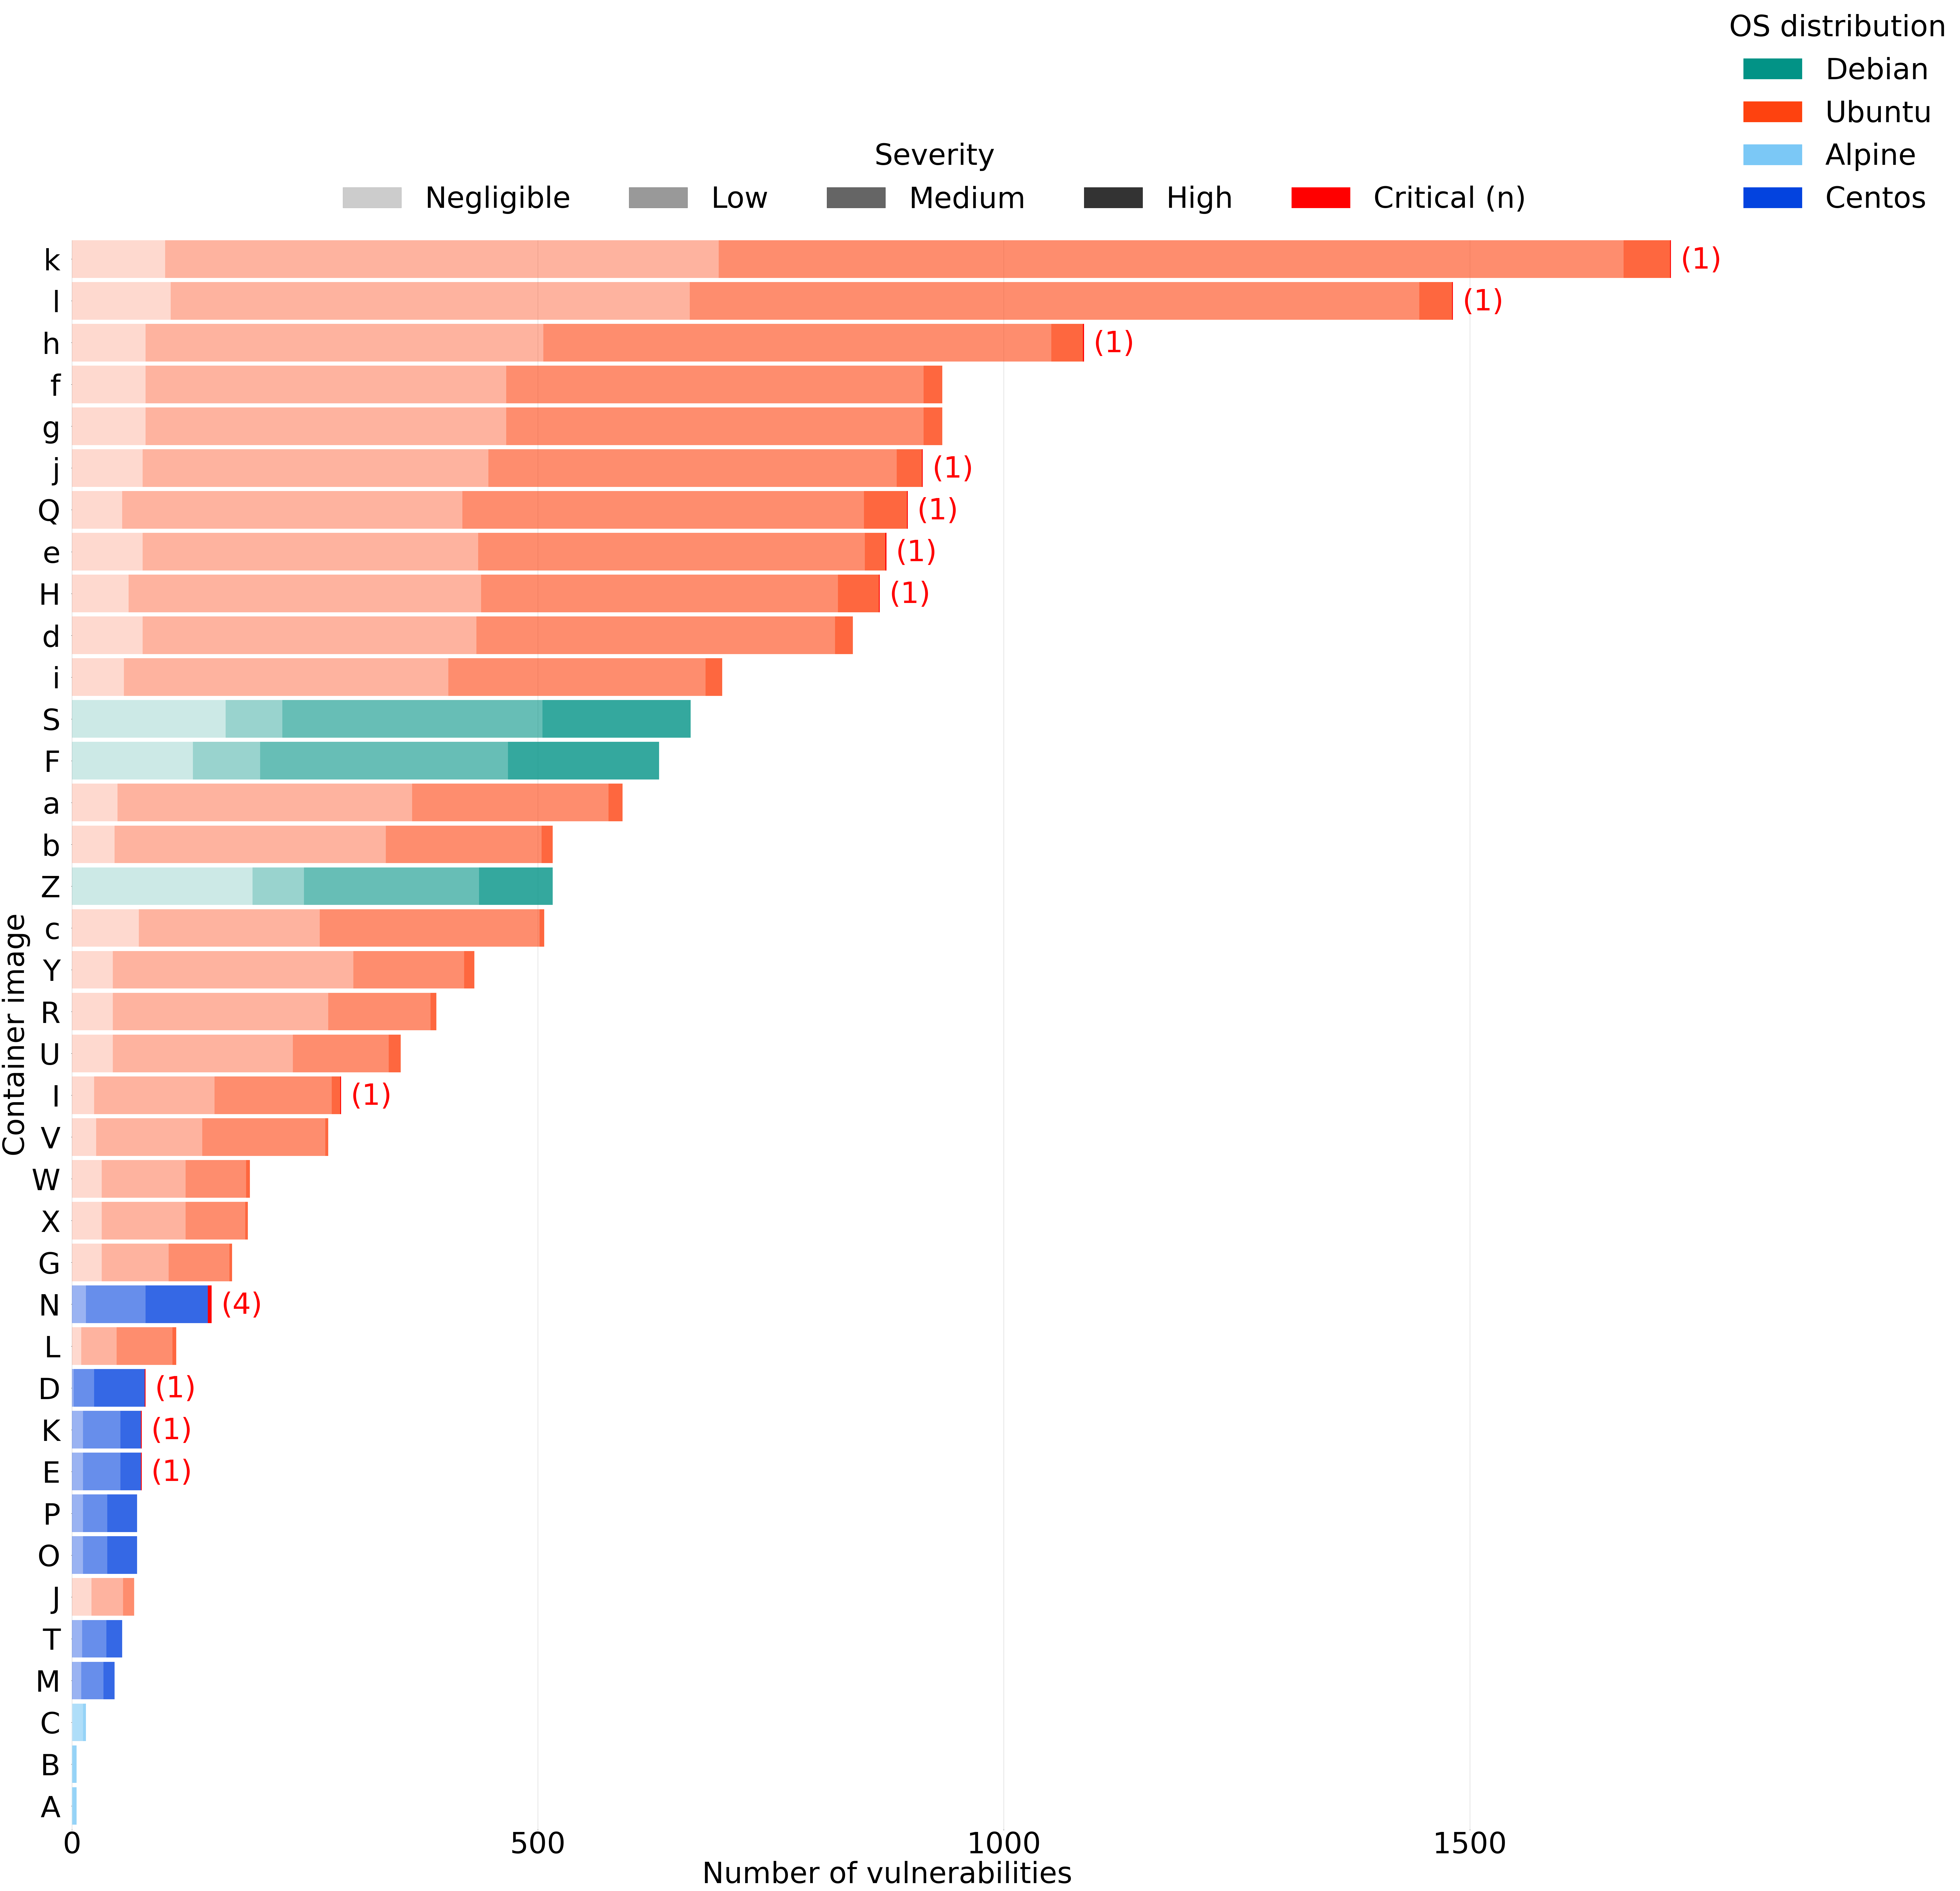

In [20]:
import matplotlib
from matplotlib import pyplot as plt

# Define font size
label_size = 100
font = {'size': label_size}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(anchore_summary, ax)

plt.savefig('./Figures/by_status_anchore.pdf', bbox_inches="tight")
plt.show()

## Clair

The Clair overview isobtained from the same vul_plot function:

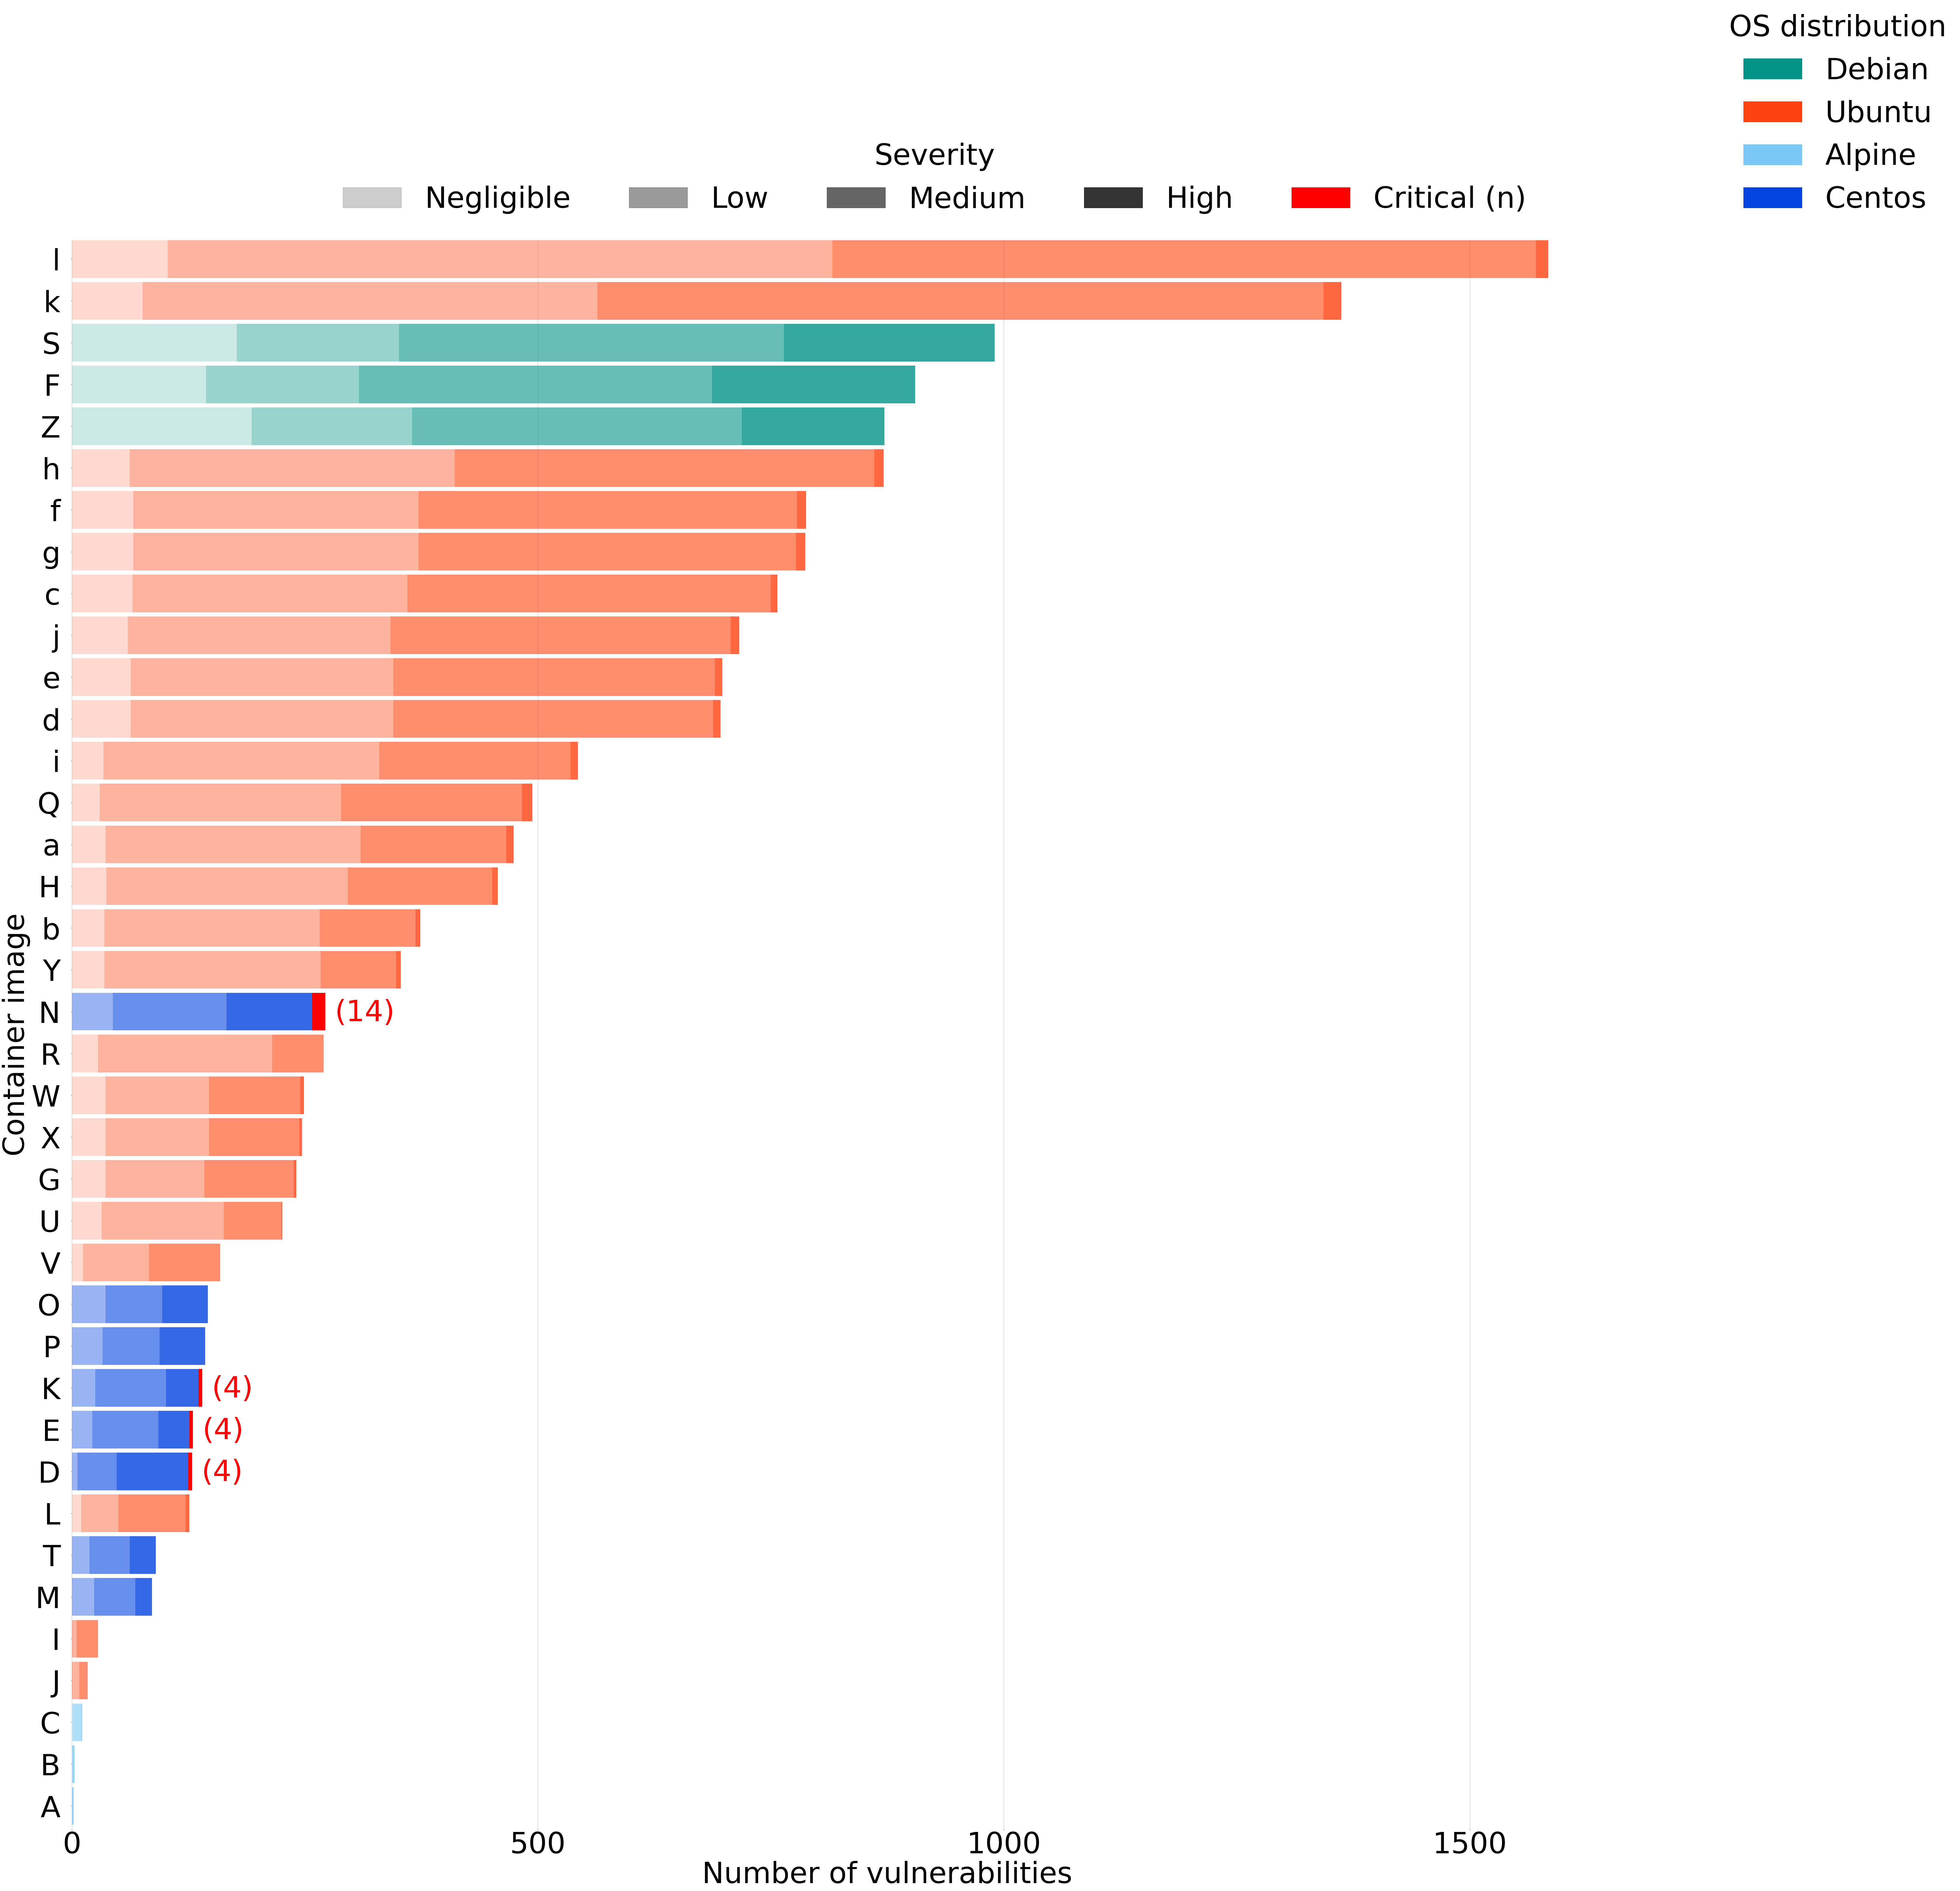

In [21]:
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(clair_summary, ax)

plt.savefig('./Figures/by_status_clair.pdf', bbox_inches="tight")
plt.show()

Note: for brevity, this figure wasn't added to the paper. Although results are not identical to Anchore's, the trends remain consistent. Discrepancies between scanners are discussed in Section 4 of this notebook and in the paper.

## Vuls

Finally, we can plot an overview of Vuls' results using the same function:

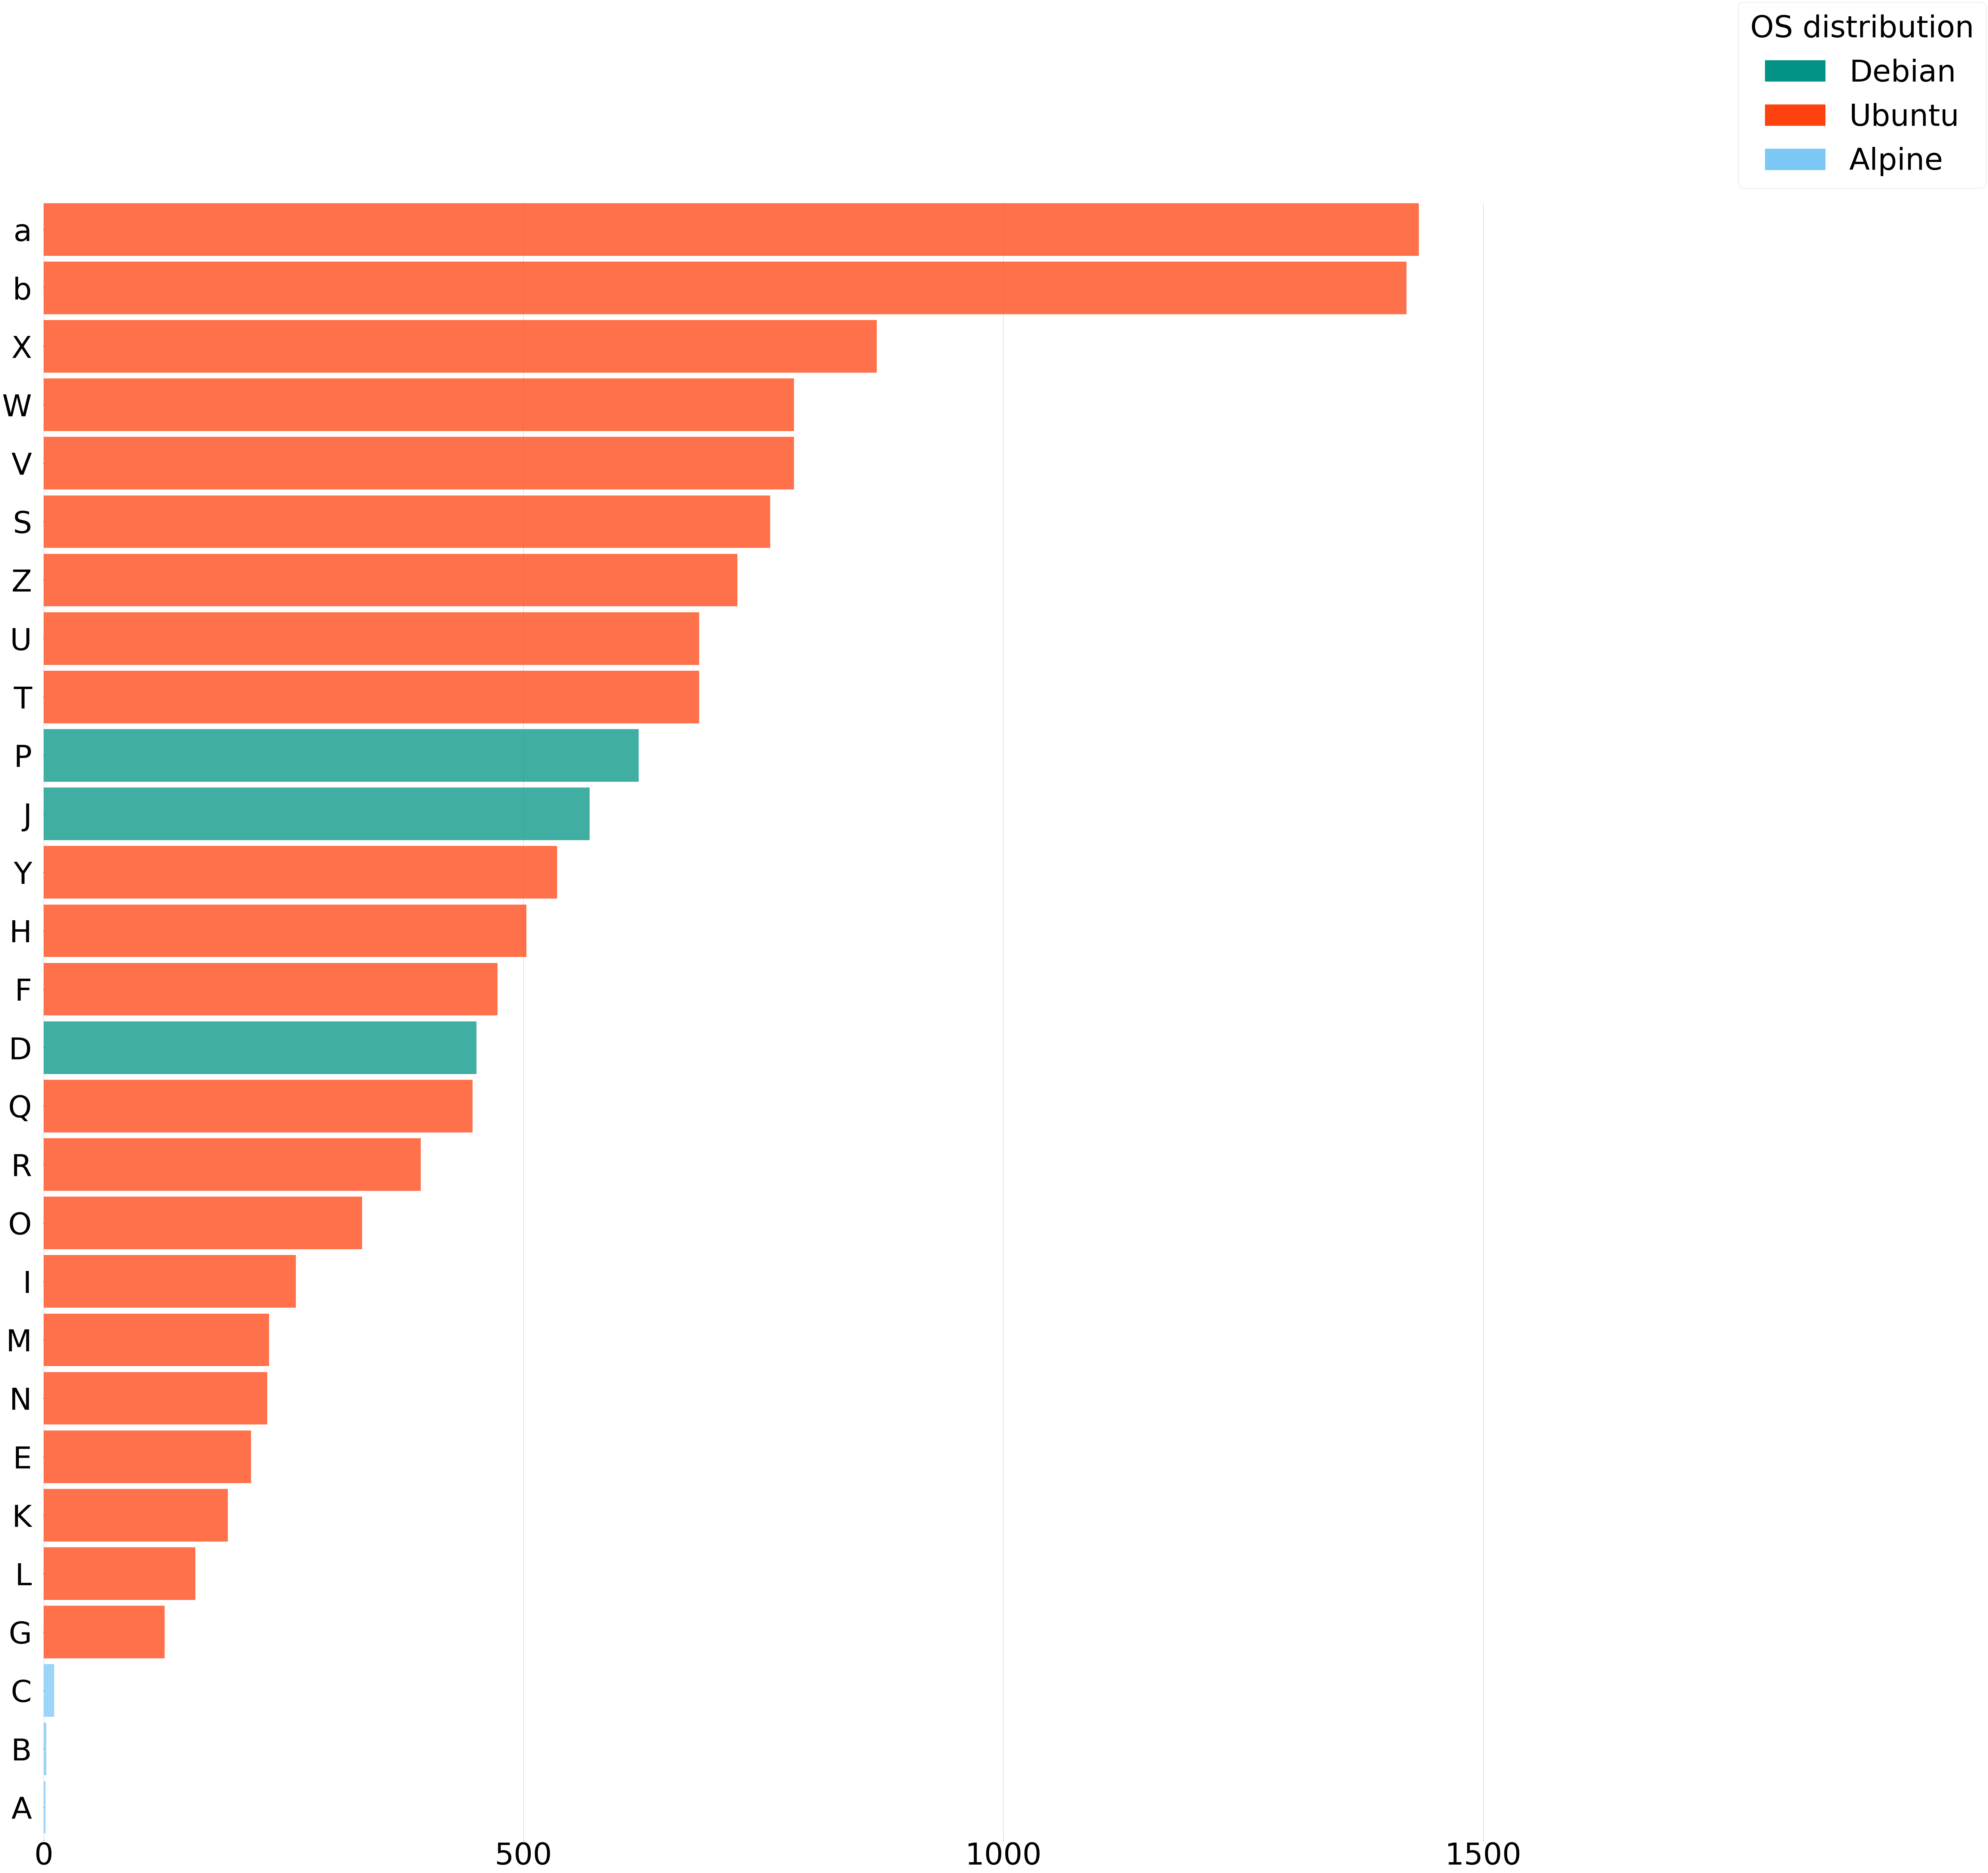

In [22]:
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(vuls_summary, ax, severities=False)

plt.savefig('./Figures/by_status_vuls.pdf', bbox_inches="tight")
plt.show()

## Vulnerabilities by number of packages, before and after update

Here we plot the number of vulnerabilities vs the number of packages in the container image. We plot side by side the values obtained before and after package update and draw regression lines, to quantify the effect of package updates on the detected vulnerabilities.

We use colors to identify OS distributions, consistently with the previous plot.

In [23]:
def update_plot(df_summary, ax, ay):
    '''
    Parameters
    ----------
    df : the summary data frame to plot. Example: anchore_summary.
    ax: a matplotlib axes object where the graph before update will be plotted.
    ax: a matplotlib axes object where the graph after update will be plotted.
    
    Returns
    -------
    None
    '''
    
    import scipy.stats  # for linregress
    import numpy as np  
    size = 10000  # marker size in the scatter plots
    
    packages = df_summary['Packages'].to_numpy()
    total = df_summary['Total'].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(packages, total)
    print(f'Before update: p={p_value}')
    ax.plot(packages, intercept + slope*packages, color='black', linewidth=3)
    ax.scatter(df_summary['Packages'], df_summary['Total'],
               s=size, color=df_summary['Color'], alpha=0.75, marker='o')
    ax.text(700, 1200, f'y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}')

    df1 = df_summary[df_summary.Total_after_update >= 0 ] # filters None
    packages = df1['Packages'].to_numpy()
    total = df1['Total_after_update'].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(packages, total)
    print(f'After update: p={p_value}')
    ay.plot(packages, intercept + slope*packages, color='black', linewidth=3)
    ay.scatter(df_summary['Packages'], df_summary['Total_after_update'],
               s=size, color=df_summary['Color'], alpha=0.75, marker='o')
    ay.text(700, 500, f'y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}')

    ymin = -50
    ymax = 1750
    xmin = 0
    xmax = 900
    for a in [ax, ay]:
        a.set_ylim(ymin, ymax)
        a.set_xlim(xmin, xmax)
        a.set_xlabel('Number of packages')

    ax.set_title('Before update')
    ax.set_ylabel('Number of vulnerabilities')
    ay.set_title('After update')


In [24]:
fig, (ax, ay) = plt.subplots(1, 2, figsize=(200, 100))
update_plot(anchore_summary, ax, ay)
plt.savefig('./Figures/update.pdf', bbox_inches="tight")
plt.show()

Before update: p=7.904925765646309e-11
After update: p=2.0033332887070155e-08


## Vulnerabilities after minification

Here we plot a grouped bar chart where each group is associated with a container image that was minified. Each group has 3 bars: the first one represents the number of vulnerabilities after update, the second one is the number of vulnerabilities after minification, and the third one is the number of vulnerabilities after both operations were applied. We indicate the initial number of vulnerabilities in the image as a background frame.

Colors still represent OS distributions, consistently with the previous plots. Transparency now represent the operation applied to the image (update, minification, both operations, or none).

In [25]:
def minif_plot(df_summary, ax):
    '''
    Parameters
    ----------
    df : the summary data frame to plot. Example: anchore_summary.
    ax: a matplotlib axes object where the graph will be plotted.
    
    Returns
    -------
    None
    '''
        
    from numpy import arange
    
    # Filter images that were both updated and minified
    df1 = df_summary[df_summary.Total_after_both >= 0][df_summary.Total_after_update >= 0] 
    
    width=0.3  # width of the histogram bars
    
    ax.invert_yaxis()
    
    # Background rectangle representing the initial number of vulnerabilities (all severities)
    ax.barh(arange(5), df1['Total'], width, color=df1['Color'], alpha=0.1)
    ax.barh(arange(5)+width, df1['Total'], width, color=df1['Color'], alpha=0.1)
    ax.barh(arange(5)+width*2, df1['Total'], width, color=df1['Color'], alpha=0.1)

    # Add a bar for each operation
    ax.barh(arange(5), df1['Total_after_update'], width, color=df1['Color'],  alpha=0.25)
    ax.barh(arange(5)+width, df1['Total_after_minification'], width, color=df1['Color'], alpha=0.5)
    ax.barh(arange(5)+2*width, df1['Total_after_both'], width, color=df1['Color'], alpha=0.75)

    # Legend
    operations = ['None', 'Update', 'Minification', 'Update & Minification']
    import matplotlib.patches as mpatches
    patches = []
    for i in range(4):
        if i == 0:
            alpha = 0.1
        else:
            alpha = i/4
        patches += [ mpatches.Patch(color=(0, 0, 0, alpha), label=operations[i])]

    ax.legend(handles=patches, bbox_to_anchor=(0.15, 1), ncol=5, loc='lower left', fontsize=label_size,
              title='Operation applied')
    ax.legend_.set_frame_on(False)

    # Figure layout
    ax.set_yticklabels(df1['Abbrv'])
    ax.set_yticks(width+arange(5))

    ax.set_frame_on(False)
    
    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(0, 1750)

    ax.set_ylabel('Container image')
    ax.set_xlabel('Number of vulnerabilities')

<ipython-input-25-8b6c67662e64>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_summary[df_summary.Total_after_both >= 0][df_summary.Total_after_update >= 0]
<ipython-input-25-8b6c67662e64>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1['Abbrv'])


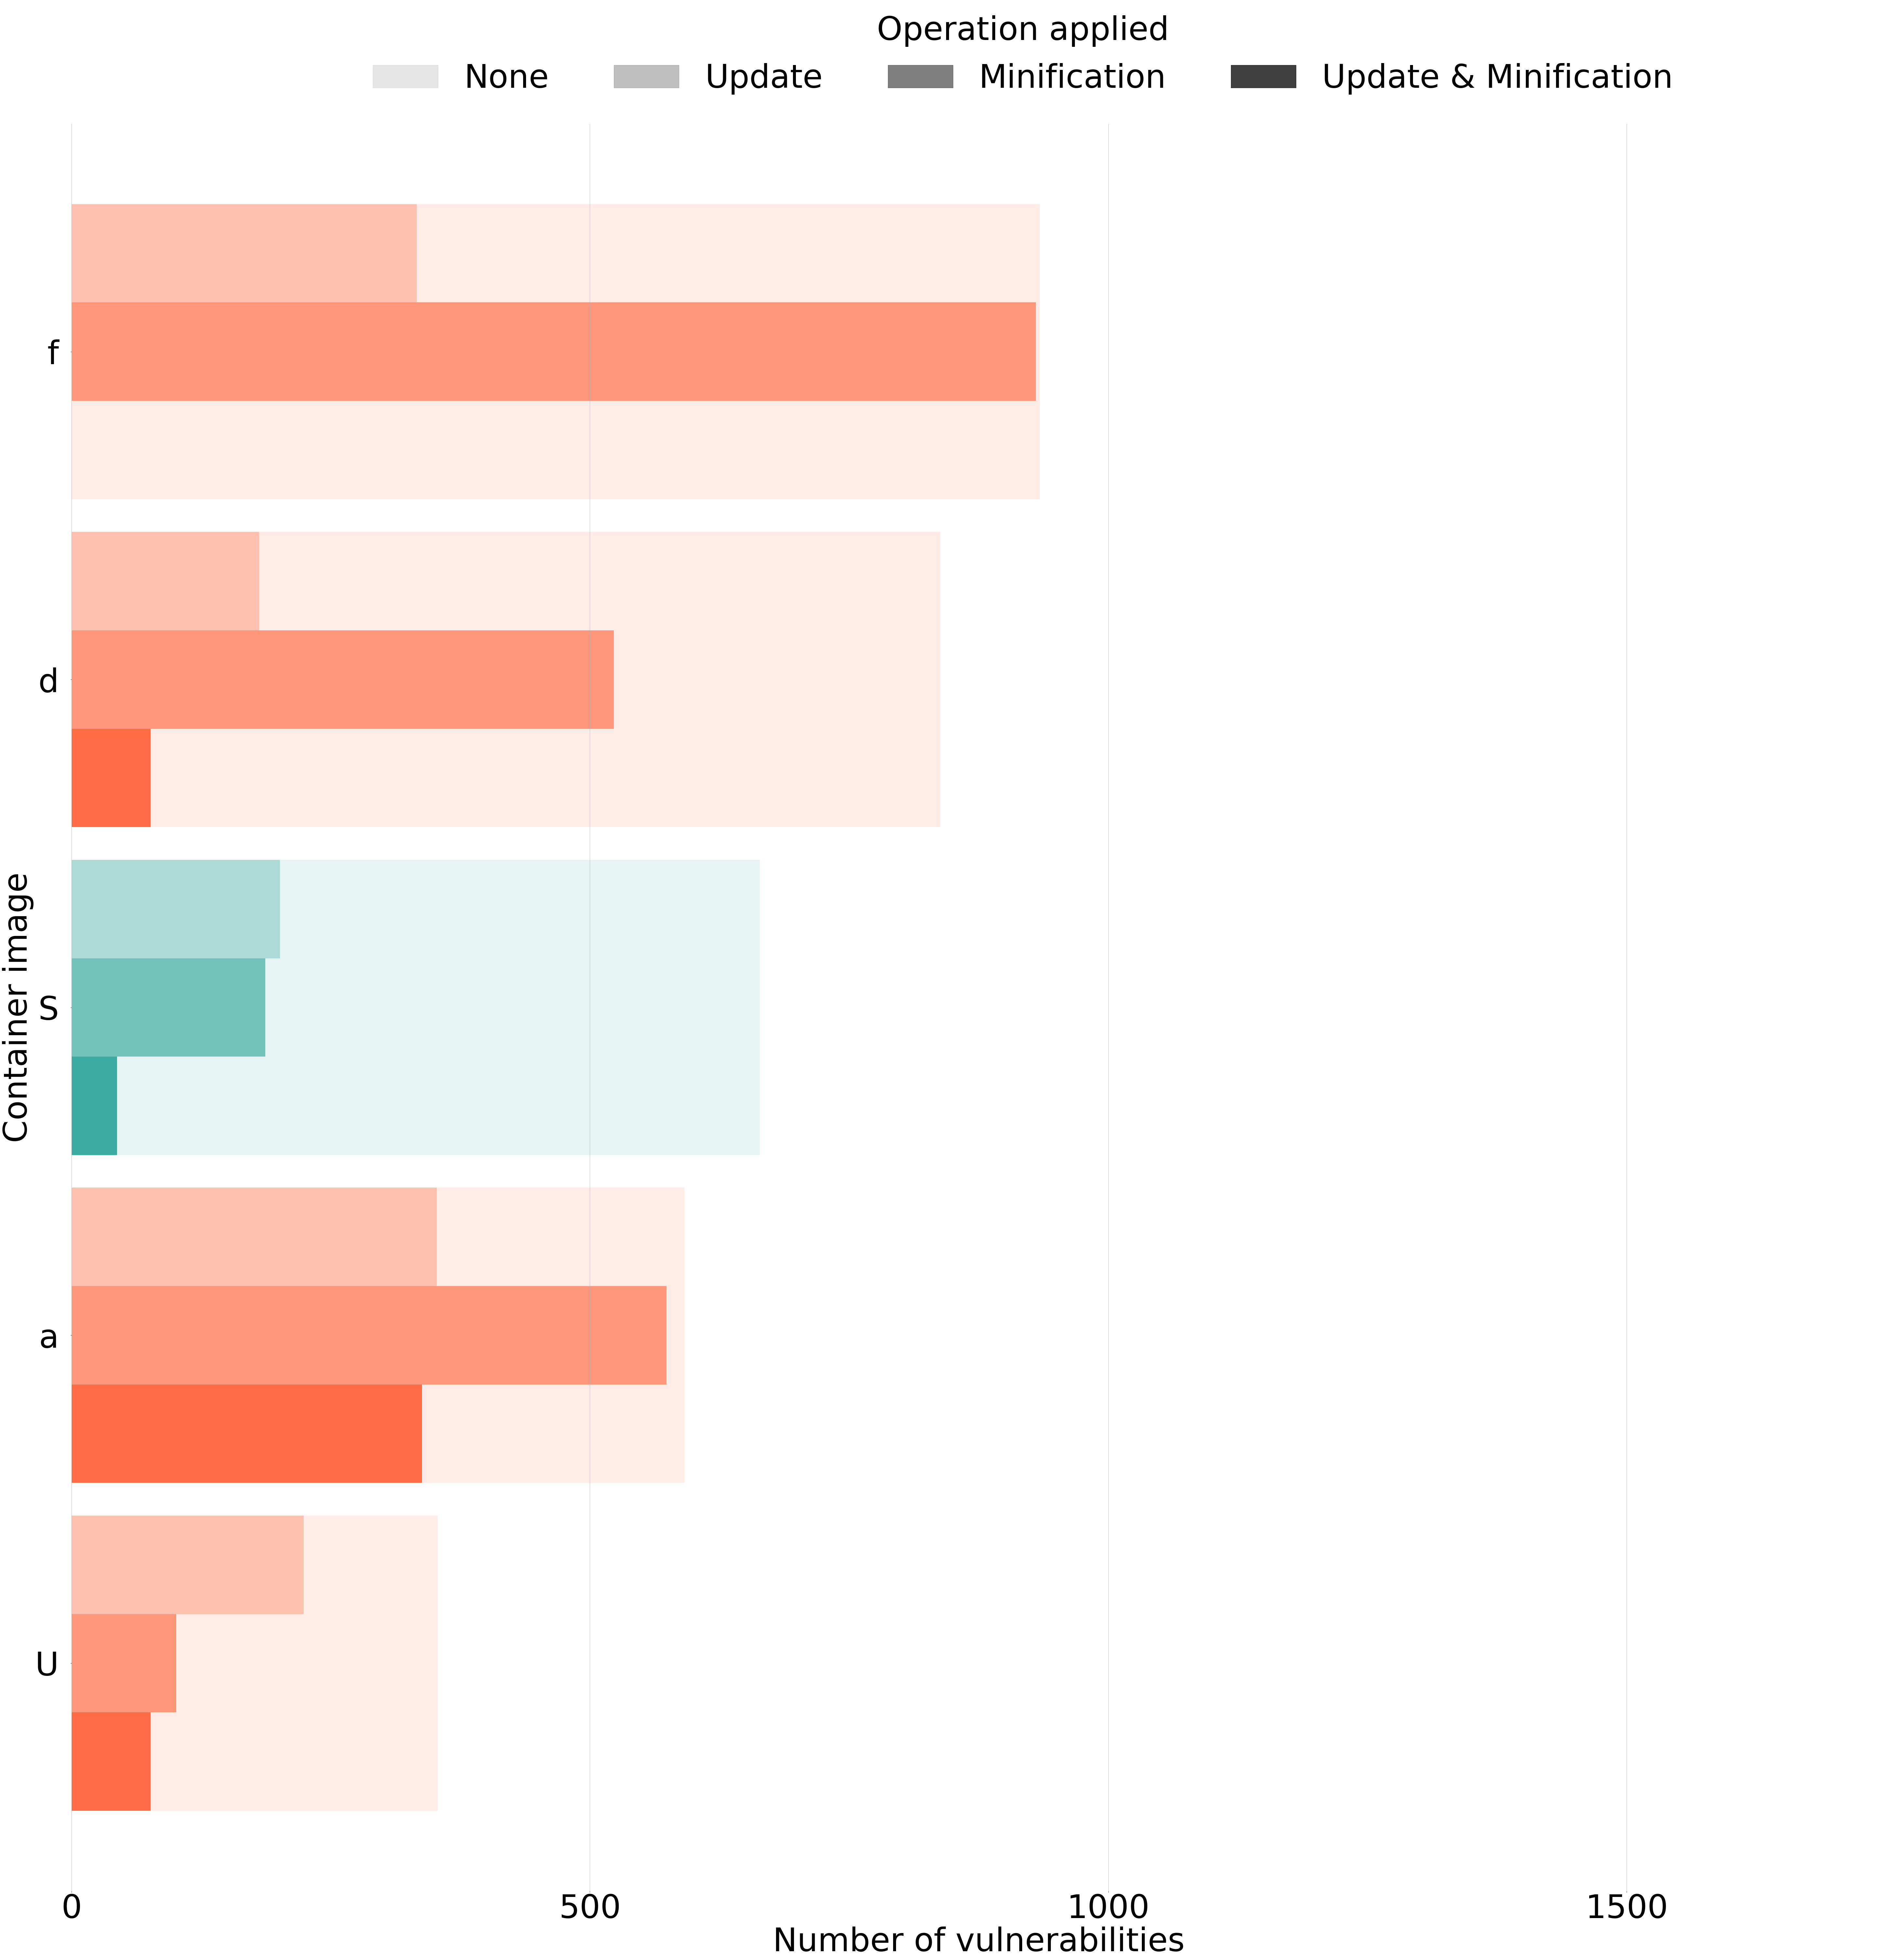

In [26]:
fig, ax = plt.subplots(figsize=(100,100))
minif_plot(anchore_summary, ax)
plt.savefig('./Figures/update_and_minif.pdf', bbox_inches="tight")
plt.show()

## Putting all the figures together

We aggregate the previous figures in a single one (included in the paper), to provide a more compact overview of our results. We do this by creating 4 matplotlib axes and passing them to the functions defined previously:

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(200,200))

# Add labels to sub-figures
label = [ 'A', 'B', 'C', 'D']
for i, ax in enumerate((axs[0,0], axs[0,1], axs[1,0], axs[1,1])):
    offset = 1.1
    ax.text(0, offset, label[i], transform=ax.transAxes,
          fontsize=200, fontweight='bold', va='top', ha='right')

# Plot each subfigure in its axes object
vul_plot(anchore_summary, axs[0,0])
minif_plot(anchore_summary, axs[0, 1])
update_plot(anchore_summary, axs[1,0], axs[1,1])

# This file is the one included in the paper
plt.savefig('./Figures/results.pdf', bbox_inches="tight")
plt.show()

<ipython-input-25-8b6c67662e64>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_summary[df_summary.Total_after_both >= 0][df_summary.Total_after_update >= 0]
<ipython-input-25-8b6c67662e64>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1['Abbrv'])


Before update: p=7.904925765646309e-11
After update: p=2.0033332887070155e-08


# Comparison between scanners

As we saw previously, scanners provide slightly different results. Instead of repeating the previous figure once for each scanner, which would be lengthy and difficult to compare, we provide a compact comparison of results through a Venn diagram.

## Venn diagram

For each scanner, we get the actual set of vulnerabilities found in each container image:

In [28]:
severities = [ 'Negligible', 'Low', 'Medium', 'High', 'Critical']

common_images = [x for x in vuls_files] # all images were analyzed by Vuls

# For each scanner, build a set of vulnerabilities found in each image
vul_clair = {}
vul_anchore = {}
vul_vuls = {}

for image in common_images: # pick only images that were processed by the 3 scanners
    clair_file = clair_files[image][0]
    anchore_file = anchore_files[image][0]
    vuls_file = vuls_files[image][0]
    # Fill clair vulnerabilities
    with open(clair_file, 'r') as f:
        lines = f.readlines()
    for l in lines[1:]:
        for s in severities:
            if s in l:
                if not image in vul_clair:
                    vul_clair[image] = []
                vul_clair[image] += [ l.split('|')[2].replace(s, '').strip() ]
    vul_clair[image] = set(vul_clair[image])
    # Fill anchore vulnerabilities
    with open(anchore_file, 'r') as f:
        lines = f.readlines()
    lines = [ shlex.split(line) for line in lines ][1:]
    vul_anchore[image] = set([ l[0] for l in lines[1:]])
    # Fill vuls vulnerabilities
    with open(vuls_file, 'r') as f:
        lines = f.readlines()
    vul_vuls[image] = set([ l.strip() for l in lines])

For better referencing, we label each region of the Venn diagram (intersection between 1, 2 or 3 scanners) with an integer.
The following functions combined the vulnerability sets defined above and return the vulnerabilities in each region.

In [29]:
# Return variabilities in each region of the Venn diagram, for a given image
# Regions are numbered from top to bottom and from left to right
def region_1(image):
    return vul_anchore[image].difference(vul_clair[image]).difference(vul_vuls[image])
def region_2(image):
    return vul_anchore[image].difference(vul_vuls[image]).intersection(vul_clair[image])
def region_3(image):
    return vul_clair[image].difference(vul_anchore[image]).difference(vul_vuls[image])
def region_4(image):
    return vul_anchore[image].difference(vul_clair[image]).intersection(vul_vuls[image])
def region_5(image):
    return vul_anchore[image].intersection(vul_clair[image]).intersection(vul_vuls[image])
def region_6(image):
    return vul_vuls[image].difference(vul_anchore[image]).intersection(vul_clair[image])
def region_7(image):
    return vul_vuls[image].difference(vul_anchore[image]).difference(vul_clair[image])

We can now compute the number of vulnerabilities in each region by summing the sizes of the sets returned by the previous functions across all images.

In [30]:
# Compute sums of intersections, among all images
n_r_1 = sum([len(region_1(image)) for image in vuls_files])
n_r_2 = sum([len(region_2(image)) for image in vuls_files])
n_r_3 = sum([len(region_3(image)) for image in vuls_files])
n_r_4 = sum([len(region_4(image)) for image in vuls_files])
n_r_5 = sum([len(region_5(image)) for image in vuls_files])
n_r_6 = sum([len(region_6(image)) for image in vuls_files])
n_r_7 = sum([len(region_7(image)) for image in vuls_files])


# print Jaccard coefficients
d_anchore_clair = (n_r_2 + n_r_5)/(n_r_2 + n_r_5 + n_r_1 + n_r_3 + n_r_4 + n_r_6)
d_anchore_vuls = (n_r_4 + n_r_5)/(n_r_4 + n_r_5 + n_r_1 + n_r_2 + n_r_7 + n_r_6)
d_vuls_clair = (n_r_5 + n_r_6)/(n_r_5 + n_r_6 + n_r_2 + n_r_3 + n_r_4 + n_r_7)
print(f'Jaccard(Anchore,Clair)={round(d_anchore_clair, 2)}')
print(f'Jaccard(Anchore,Vuls)={round(d_anchore_vuls, 2)}')
print(f'Jaccard(Vuls, Clair)={round(d_vuls_clair, 2)}')


Jaccard(Anchore,Clair)=0.59
Jaccard(Anchore,Vuls)=0.59
Jaccard(Vuls, Clair)=0.83


We can finally draw the Venn diagram using 3 circles and 1 label per region:

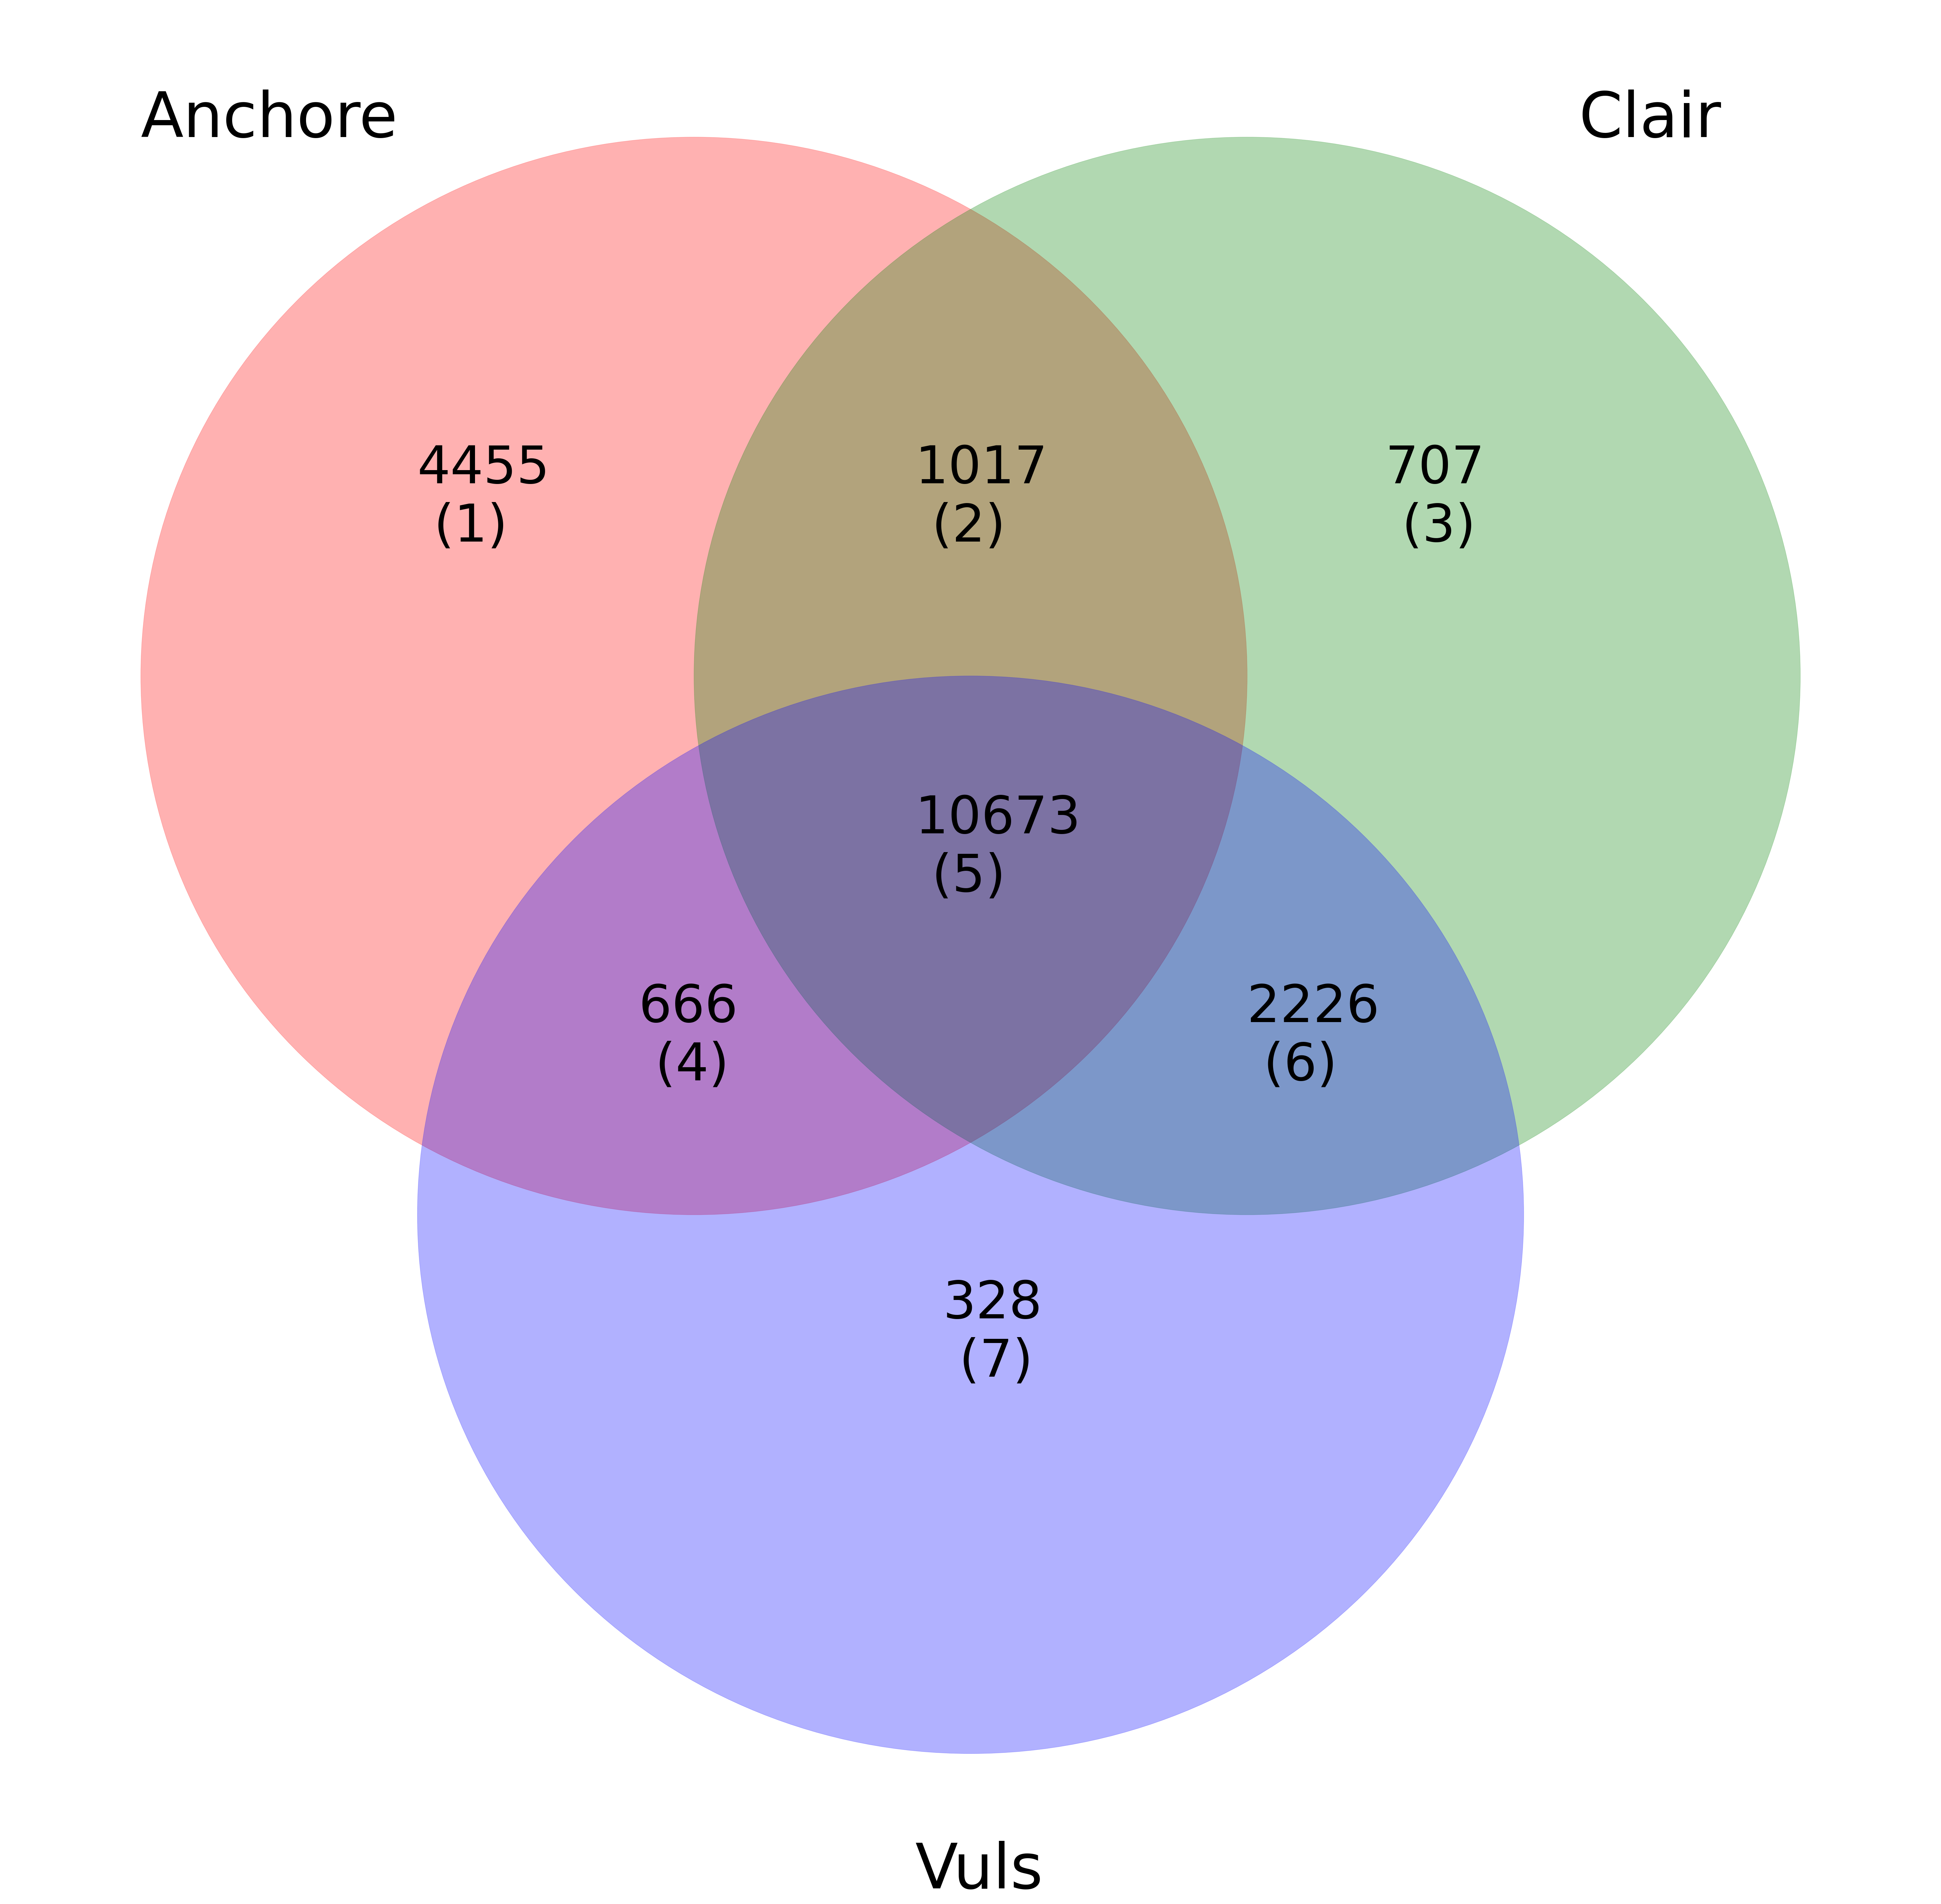

In [31]:
from matplotlib import pyplot as plt

label_size = 150
figure, axes = plt.subplots(figsize=(100,100))
alpha=0.3
anchore_circle = plt.Circle((0.4, 0.6), 0.2, alpha=alpha, color='red')
clair_circle = plt.Circle((0.6, 0.6), 0.2, alpha=alpha, color='green')
vuls_circle = plt.Circle((0.5, 0.4), 0.2, alpha=alpha, color='blue')

axes.add_artist(anchore_circle)
axes.add_artist(clair_circle)
axes.add_artist(vuls_circle)

axes.text(0.3, 0.65, str(n_r_1)+'\n (1)', color='black', fontsize=label_size)
axes.text(0.48, 0.65, str(n_r_2)+'\n (2)', color='black', fontsize=label_size)
axes.text(0.65, 0.65, str(n_r_3)+'\n (3)', color='black', fontsize=label_size)
axes.text(0.38, 0.45, str(n_r_4)+'\n (4)', color='black', fontsize=label_size)
axes.text(0.48, 0.52, str(n_r_5)+'\n (5)', color='black', fontsize=label_size)
axes.text(0.6, 0.45, str(n_r_6)+'\n (6)', color='black', fontsize=label_size)
axes.text(0.49, 0.34, str(n_r_7)+'\n (7)', color='black', fontsize=label_size)

axes.text(0.2, 0.8, 'Anchore', fontsize=1.2*label_size)
axes.text(0.72, 0.8, 'Clair', fontsize=1.2*label_size)
axes.text(0.48, 0.15, 'Vuls', fontsize=1.2*label_size)

axes.set_xlim(0.15, 0.85)
axes.set_ylim(0.15, 0.85)

axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.set_frame_on(False)

# This file is included in the paper
plt.savefig('./Figures/venn.pdf', bbox_inches="tight")

plt.show()

## Detailed analysis

Here we analyse the content of the Venn diagram region by region, in particular the list of vulnerable packages, to better characterize the differences between scanners.

### Vulnerable packages

For each scanner we build a data frame containing the packages associated with each detected CVE:

In [32]:
# Get details about all vulnerabilities detected by Anchore
all_vulns_anchore = pd.DataFrame(columns=['Image', 'CVE', 'Package', 'Severity'])

for image in common_images:
    file_name = anchore_files[image][0]
    with open(file_name, 'r') as f:
        lines = f.readlines()
    for line in lines[1:]:
        s = shlex.split(line)
        cve = s[0]
        package = s[1]
        severity = s[2]
        all_vulns_anchore = all_vulns_anchore.append({
            'Image': image,
            'CVE': cve,
            'Package': package,
            'Severity': severity
        }, ignore_index=True)
                

In [33]:
all_vulns_anchore

Image             CVE  \
0      gkiar/onevoxel:v0.3.0rc2  CVE-2018-20843   
1      gkiar/onevoxel:v0.3.0rc2  CVE-2019-12900   
2      gkiar/onevoxel:v0.3.0rc2  CVE-2019-14697   
3      gkiar/onevoxel:v0.3.0rc2  CVE-2019-14697   
4      gkiar/onevoxel:v0.3.0rc2  CVE-2019-14697   
...                         ...             ...   
29177                 bids/niak   CVE-2019-9587   
29178                 bids/niak   CVE-2019-9587   
29179                 bids/niak   CVE-2019-9587   
29180                 bids/niak   CVE-2019-9587   
29181                 bids/niak   CVE-2019-9587   

                                      Package    Severity  
0                              expat-2.2.5-r0        High  
1                             libbz2-1.0.6-r6        High  
2                              musl-1.1.18-r3        High  
3                          musl-dev-1.1.18-r3        High  
4                        musl-utils-1.1.18-r3        High  
...                                       ...         ...  
29177       libptexenc1-2015.20160222.37495-1  Negligible  
29178       libsynctex1-2015.20160222.37495-1  Negligible  
29179       libtexlua52-2015.20160222.37495-1  Negligible  
29180     libtexluajit2-2015.20160222.37495-1  Negligible  
29181  texlive-binaries-2015.20160222.37495-1  Negligible  

[29182 rows x 4 columns]

In [34]:
# Get details about all vulnerabilities detected by Clair
all_vulns_clair = pd.DataFrame(columns=['Image', 'CVE', 'Package', 'Severity'])
severities = [ 'Unknown', 'Negligible', 'Low', 'Medium', 'High', 'Critical']

for image in common_images:
    file_name = clair_files[image][0]
    with open(file_name, 'r') as f:
        lines = f.readlines()
    for line in lines[1:]:
        for s in severities:
            if s in line:
                splits = line.split('|')
                cve = splits[2].replace(s, '').strip()
                package = splits[3].strip()+'-'+splits[4].strip()
                severity = s
                all_vulns_clair = all_vulns_clair.append({
                    'Image': image,
                    'CVE': cve,
                    'Package': package,
                    'Severity': severity
                }, ignore_index=True)
                continue

In [35]:
all_vulns_clair

Image             CVE  \
0      gkiar/onevoxel:v0.3.0rc2  CVE-2018-20843   
1      gkiar/onevoxel:v0.3.0rc2  CVE-2019-14697   
2              bids/rshrf:1.0.1  CVE-2018-20843   
3              bids/rshrf:1.0.1  CVE-2019-14697   
4              bids/rshrf:1.0.1  CVE-2019-12904   
...                         ...             ...   
15279                 bids/niak  CVE-2017-13758   
15280                 bids/niak  CVE-2019-13137   
15281                 bids/niak  CVE-2018-16640   
15282                 bids/niak   CVE-2019-7175   
15283                 bids/niak  CVE-2017-13732   

                                Package    Severity  
0                        expat-2.2.5-r0        High  
1                        musl-1.1.18-r3        High  
2                        expat-2.2.5-r0        High  
3                       musl-1.1.19-r10        High  
4                    libgcrypt-1.8.3-r0      Medium  
...                                 ...         ...  
15279  imagemagick-8:6.8.9.9-7ubuntu5.9  Negligible  
15280  imagemagick-8:6.8.9.9-7ubuntu5.9  Negligible  
15281  imagemagick-8:6.8.9.9-7ubuntu5.9  Negligible  
15282  imagemagick-8:6.8.9.9-7ubuntu5.9  Negligible  
15283     ncurses-6.0+20160213-1ubuntu1  Negligible  

[15284 rows x 4 columns]

In [36]:
# Get details about all vulnerabilities detected by Vuls
all_vulns_vuls = pd.DataFrame(columns=['Image', 'CVE', 'Package', 'Severity'])

for image in common_images:
    file_name = vuls_files[image][0]
    with open(file_name, 'r') as f:
        lines = f.readlines()
    for line in lines[1:]:
        cve = line.strip()
        all_vulns_vuls = all_vulns_vuls.append({
            'Image': image,
            'CVE': cve,
            'Package': None,
            'Severity': None
        }, ignore_index=True)
    print(image, file_name, len(lines))
                

gkiar/onevoxel:v0.3.0rc2 ./Data/Vuls/Boutiques/onevoxel.csv 2
bids/rshrf:1.0.1 ./Data/Vuls/BIDS/rshrf.csv 3
gkiar/mask2boundary:v0.1.0 ./Data/Vuls/Boutiques/mask2boundary.csv 11
bids/nipypelines:0.3.0 ./Data/Vuls/BIDS/nipypelines.csv 451
bids/baracus ./Data/Vuls/BIDS/baracus.csv 216
bids/rs_signal_extract:0.1 ./Data/Vuls/BIDS/rs_signal_extract.csv 473
bids/magetbrain ./Data/Vuls/BIDS/magetbrain.csv 126
bids/brainiak-srm ./Data/Vuls/BIDS/brainiak-srm.csv 503
gkiar/dwipreproc_fsl-5.0.11_minified ./Data/Vuls/Boutiques/dwipreproc_fsl-5.0.11_minified.csv 263
bids/mindboggle:0.0.4-1 ./Data/Vuls/BIDS/mindboggle.csv 569
bids/freesurfer ./Data/Vuls/BIDS/freesurfer.csv 192
bids/mrtrix3_connectome ./Data/Vuls/BIDS/mrtrix3_connectome.csv 158
bids/spm ./Data/Vuls/BIDS/spm.csv 235
bids/aa:v0.2.0 ./Data/Vuls/BIDS/aa.csv 233
poldracklab/mriqc:0.15.0 ./Data/Vuls/BIDS/mriqc.csv 332
bids/hcppipelines:v3.17.0-18 ./Data/Vuls/BIDS/hcppipelines.csv 620
poldracklab/fmriprep:1.2.3 ./Data/Vuls/Boutiques/fmripre

In [37]:
all_vulns_vuls

Image             CVE Package Severity
0        gkiar/onevoxel:v0.3.0rc2  CVE-2018-20843    None     None
1                bids/rshrf:1.0.1  CVE-2018-20843    None     None
2                bids/rshrf:1.0.1  CVE-2019-12904    None     None
3      gkiar/mask2boundary:v0.1.0   CVE-2019-9948    None     None
4      gkiar/mask2boundary:v0.1.0  CVE-2018-14550    None     None
...                           ...             ...     ...      ...
13860                   bids/niak  CVE-2018-16866    None     None
13861                   bids/niak  CVE-2017-10345    None     None
13862                   bids/niak   CVE-2018-2790    None     None
13863                   bids/niak   CVE-2018-3139    None     None
13864                   bids/niak   CVE-2017-7407    None     None

[13865 rows x 4 columns]

### Analysis by region of the Venn diagram

We can now get the list of vulnerable packages in each region of the Venn diagram:

In [38]:
def get_packages_cve(cve, image, all_vulns):
    return set( all_vulns[all_vulns['CVE'] == cve][all_vulns['Image'] == image]['Package'])

# TODO: get info about packages in Vuls

In [39]:
# Get the set of packages in region (1) of the Venn diagram
packages = set()
for image in vuls_files:
    for cve in region_1(image):
        packages = packages.union(get_packages_cve(cve, image, all_vulns_anchore))
packages

<ipython-input-38-2da894b017e5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return set( all_vulns[all_vulns['CVE'] == cve][all_vulns['Image'] == image]['Package'])


{'e2fslibs-1.42.13-1ubuntu1',
 'e2fsprogs-1.42.13-1ubuntu1',
 'gnupg-1.4.18-6',
 'gpgv-1.4.18-6',
 'libbz2-1.0.6-r6',
 'libcomerr2-1.42.13-1ubuntu1',
 'libcrypto1.0-1.0.2q-r0',
 'libcrypto1.1-1.1.1a-r1',
 'libss2-1.42.13-1ubuntu1',
 'libssl1.0-1.0.2q-r0',
 'libssl1.1-1.1.1a-r1',
 'linux-libc-dev-3.13.0-119.166',
 'linux-libc-dev-3.13.0-128.177',
 'linux-libc-dev-3.13.0-139.188',
 'linux-libc-dev-3.13.0-153.203',
 'linux-libc-dev-3.13.0-96.143',
 'linux-libc-dev-3.16.39-1',
 'linux-libc-dev-3.16.43-2',
 'linux-libc-dev-3.16.56-1+deb8u1',
 'linux-libc-dev-4.15.0-50.54',
 'linux-libc-dev-4.4.0-127.153',
 'linux-libc-dev-4.4.0-134.160',
 'linux-libc-dev-4.4.0-141.167',
 'linux-libc-dev-4.4.0-142.168',
 'linux-libc-dev-4.4.0-145.171',
 'linux-libc-dev-4.4.0-31.50',
 'linux-libc-dev-4.4.0-38.57',
 'linux-libc-dev-4.4.0-81.104',
 'sqlite-libs-3.25.3-r0',
 'sqlite-libs-3.26.0-r3'}

In [40]:
# Get the set of packages in region (2) of the Venn diagram

packages = set()
for image in vuls_files:
    for cve in region_2(image):
        packages = packages.union(get_packages_cve(cve, image, all_vulns_anchore))

packages

<ipython-input-38-2da894b017e5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return set( all_vulns[all_vulns['CVE'] == cve][all_vulns['Image'] == image]['Package'])


{'e2fslibs-1.42.13-1ubuntu1',
 'e2fsprogs-1.42.13-1ubuntu1',
 'e2fsprogs-1.44.1-1',
 'e2fsprogs-1.44.1-1ubuntu1.1',
 'gnupg-1.4.18-6',
 'gnupg-1.4.18-7+deb8u3',
 'gpgv-1.4.18-6',
 'gpgv-1.4.18-7+deb8u3',
 'libcom-err2-1.44.1-1',
 'libcom-err2-1.44.1-1ubuntu1.1',
 'libcomerr2-1.42.13-1ubuntu1',
 'libdb5.3-5.3.28-7~deb8u1',
 'libdb5.3-5.3.28-9',
 'libext2fs2-1.44.1-1',
 'libext2fs2-1.44.1-1ubuntu1.1',
 'libgd3-2.1.0-3ubuntu0.3',
 'libgd3-2.1.0-3ubuntu0.5',
 'libgd3-2.1.0-3ubuntu0.6',
 'libgd3-2.1.0-3ubuntu0.8',
 'libgd3-2.1.0-5+deb8u11',
 'libgd3-2.1.0-5+deb8u9',
 'libidn11-1.29-1+deb8u2',
 'liblcms2-2-2.6-3+deb8u1',
 'libss2-1.42.13-1ubuntu1',
 'libss2-1.44.1-1',
 'libss2-1.44.1-1ubuntu1.1',
 'libudev1-229-4ubuntu17',
 'libx265-79-1.9-3',
 'linux-libc-dev-3.16.39-1',
 'linux-libc-dev-3.16.43-2',
 'linux-libc-dev-3.16.56-1+deb8u1',
 'systemd-sysv-229-4ubuntu17'}

In [41]:
get_packages_cve('CVE-2019-13627', 'bids/nipypelines:0.3.0', all_vulns_anchore)

<ipython-input-38-2da894b017e5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return set( all_vulns[all_vulns['CVE'] == cve][all_vulns['Image'] == image]['Package'])


{'libgcrypt20-1.6.2-4+b1'}

In [42]:
set(list(all_vulns_anchore['Image'].to_numpy()))

{'bids/aa:v0.2.0',
 'bids/baracus',
 'bids/brainiak-srm',
 'bids/cpac:v1.0.1a_22',
 'bids/dparsf:v4.3.12',
 'bids/example',
 'bids/fibredensityandcrosssection',
 'bids/freesurfer',
 'bids/hcppipelines:v3.17.0-18',
 'bids/hyperalignment',
 'bids/magetbrain',
 'bids/mindboggle:0.0.4-1',
 'bids/mrtrix3_connectome',
 'bids/ndmg',
 'bids/ndmg:v0.1.0',
 'bids/niak',
 'bids/nipypelines:0.3.0',
 'bids/oppni:v0.7.0-1',
 'bids/rs_signal_extract:0.1',
 'bids/rshrf:1.0.1',
 'bids/spm',
 'bids/tracula:v6.0.0-4',
 'gkiar/dwipreproc_fsl-5.0.11_minified',
 'gkiar/mask2boundary:v0.1.0',
 'gkiar/onevoxel:v0.3.0rc2',
 'poldracklab/fmriprep:1.2.3',
 'poldracklab/fmriprep:unstable',
 'poldracklab/mriqc:0.15.0'}

In [43]:
all_vulns_anchore

Image             CVE  \
0      gkiar/onevoxel:v0.3.0rc2  CVE-2018-20843   
1      gkiar/onevoxel:v0.3.0rc2  CVE-2019-12900   
2      gkiar/onevoxel:v0.3.0rc2  CVE-2019-14697   
3      gkiar/onevoxel:v0.3.0rc2  CVE-2019-14697   
4      gkiar/onevoxel:v0.3.0rc2  CVE-2019-14697   
...                         ...             ...   
29177                 bids/niak   CVE-2019-9587   
29178                 bids/niak   CVE-2019-9587   
29179                 bids/niak   CVE-2019-9587   
29180                 bids/niak   CVE-2019-9587   
29181                 bids/niak   CVE-2019-9587   

                                      Package    Severity  
0                              expat-2.2.5-r0        High  
1                             libbz2-1.0.6-r6        High  
2                              musl-1.1.18-r3        High  
3                          musl-dev-1.1.18-r3        High  
4                        musl-utils-1.1.18-r3        High  
...                                       ...         ...  
29177       libptexenc1-2015.20160222.37495-1  Negligible  
29178       libsynctex1-2015.20160222.37495-1  Negligible  
29179       libtexlua52-2015.20160222.37495-1  Negligible  
29180     libtexluajit2-2015.20160222.37495-1  Negligible  
29181  texlive-binaries-2015.20160222.37495-1  Negligible  

[29182 rows x 4 columns]

In [44]:
# Get the set of packages in region (4) of the Venn diagram
packages = set()
for image in vuls_files:
    for cve in region_4(image):
        packages = packages.union(get_packages_cve(cve, image, all_vulns_anchore))

packages

<ipython-input-38-2da894b017e5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return set( all_vulns[all_vulns['CVE'] == cve][all_vulns['Image'] == image]['Package'])


{'busybox-initramfs-1:1.21.0-1ubuntu1',
 'git-1:1.9.1-1ubuntu0.3',
 'git-1:1.9.1-1ubuntu0.5',
 'git-man-1:1.9.1-1ubuntu0.3',
 'git-man-1:1.9.1-1ubuntu0.5',
 'gnupg-1.4.18-6',
 'gpgv-1.4.18-6',
 'imagemagick-common-8:6.7.7.10-6ubuntu3.9',
 'libavcodec54-6:9.18-0ubuntu0.14.04.1',
 'libavcodec54-6:9.20-0ubuntu0.14.04.1',
 'libavformat54-6:9.18-0ubuntu0.14.04.1',
 'libavformat54-6:9.20-0ubuntu0.14.04.1',
 'libavutil52-6:9.18-0ubuntu0.14.04.1',
 'libavutil52-6:9.20-0ubuntu0.14.04.1',
 'libblkid1-2.20.1-5.1ubuntu20.9',
 'libcairo-gobject2-1.13.0~20140204-0ubuntu1.1',
 'libcairo-gobject2-1.14.6-1',
 'libcairo2-1.13.0~20140204-0ubuntu1.1',
 'libcairo2-1.14.6-1',
 'libcroco3-0.6.11-1',
 'libcups2-1.7.5-11+deb8u2',
 'libcups2-2.1.3-4ubuntu0.7',
 'libdbus-1-3-1.10.6-1ubuntu3.3',
 'libgcrypt20-1.6.2-4+b1',
 'libgcrypt20-1.6.3-2+deb8u2',
 'libgcrypt20-1.6.3-2+deb8u4',
 'libgdk-pixbuf2.0-0-2.32.2-1ubuntu1.5',
 'libgdk-pixbuf2.0-common-2.32.2-1ubuntu1.5',
 'libglib2.0-0-2.40.2-0ubuntu1',
 'libglib2.0

In [45]:
# Get the set of packages in region (3) of the Venn diagram
packages = set()
for image in vuls_files:
    for cve in region_3(image):
        #print(image, cve)
        packages = packages.union(get_packages_cve(cve, image, all_vulns_clair))
        #print(packages)
        #break
packages

<ipython-input-38-2da894b017e5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return set( all_vulns[all_vulns['CVE'] == cve][all_vulns['Image'] == image]['Package'])


{'-',
 'bash-4.3-7ubuntu1.5',
 'bash-4.3-7ubuntu1.7',
 'binutils-2.24-5ubuntu14.1',
 'binutils-2.24-5ubuntu14.2',
 'cups-1.7.2-0ubuntu1.7',
 'cups-1.7.2-0ubuntu1.8',
 'cups-1.7.5-11+deb8u2',
 'cups-2.1.3-4',
 'cups-2.1.3-4ubuntu0.4',
 'curl-7.35.0-1ubuntu2.10',
 'curl-7.35.0-1ubuntu2.16',
 'curl-7.35.0-1ubuntu2.8',
 'curl-7.35.0-1ubuntu2.9',
 'db5.3-5.3.28-3ubuntu3',
 'db5.3-5.3.28-3ubuntu3.1',
 'dbus-1.6.18-0ubuntu4.3',
 'dbus-1.6.18-0ubuntu4.5',
 'e2fsprogs-1.42.9-3ubuntu1.3',
 'eglibc-2.19-0ubuntu6.11',
 'eglibc-2.19-0ubuntu6.13',
 'eglibc-2.19-0ubuntu6.14',
 'eglibc-2.19-0ubuntu6.9',
 'expat-2.1.0-4ubuntu1.3',
 'expat-2.1.0-4ubuntu1.4',
 'freetype-2.5.2-1ubuntu2.5',
 'freetype-2.5.2-1ubuntu2.8',
 'glib2.0-2.40.2-0ubuntu1',
 'glib2.0-2.40.2-0ubuntu1.1',
 'gnupg-1.4.16-1ubuntu2.4',
 'gnupg-1.4.16-1ubuntu2.5',
 'graphicsmagick-1.3.18-1ubuntu3',
 'hdf5-1.8.11-5ubuntu7',
 'heimdal-1.6~git20131207+dfsg-1ubuntu1.1',
 'heimdal-1.6~git20131207+dfsg-1ubuntu1.2',
 'imagemagick-8:6.8.9.9-7ubun

In [46]:
# Get the set of packages in region (6) of the Venn diagram
packages = set()
for image in vuls_files:
    for cve in region_6(image):
        packages = packages.union(get_packages_cve(cve, image, all_vulns_clair))

packages

<ipython-input-38-2da894b017e5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return set( all_vulns[all_vulns['CVE'] == cve][all_vulns['Image'] == image]['Package'])


{'bind9-1:9.10.3.dfsg.P4-8ubuntu1',
 'bind9-1:9.10.3.dfsg.P4-8ubuntu1.10',
 'bind9-1:9.10.3.dfsg.P4-8ubuntu1.11',
 'bind9-1:9.10.3.dfsg.P4-8ubuntu1.6',
 'bind9-1:9.9.5.dfsg-9+deb8u15',
 'binutils-2.25-5',
 'binutils-2.25-5+deb8u1',
 'busybox-1:1.21.0-1ubuntu1',
 'cairo-1.14.0-2.1+deb8u2',
 'coreutils-8.23-3',
 'coreutils-8.23-4',
 'cups-1.7.5-11+deb8u2',
 'curl-7.38.0-4+deb8u11',
 'curl-7.38.0-4+deb8u5',
 'expat-2.2.5-r0',
 'expat-2.2.6-r0',
 'ffmpeg-7:2.8.6-1ubuntu2',
 'file-1:5.14-2ubuntu3.3',
 'file-1:5.22+15-2+deb8u4',
 'file-1:5.25-2ubuntu1',
 'file-1:5.25-2ubuntu1.1',
 'file-1:5.32-2ubuntu0.1',
 'gcc-4.8-4.8.3-13',
 'gcc-4.8-4.8.4-1',
 'gcc-4.9-4.9.2-10',
 'gcc-4.9-4.9.2-10+deb8u1',
 'gdcm-2.2.4-1.1ubuntu4',
 'gifsicle-1.78-1',
 'git-1:1.9.1-1ubuntu0.3',
 'git-1:1.9.1-1ubuntu0.5',
 'git-1:2.1.4-2.1+deb8u3',
 'git-1:2.17.1-1ubuntu0.1',
 'git-1:2.7.4-0ubuntu1',
 'git-1:2.7.4-0ubuntu1.1',
 'git-1:2.7.4-0ubuntu1.3',
 'git-1:2.7.4-0ubuntu1.4',
 'glibc-2.19-13',
 'glibc-2.19-18+deb8u10

TODO: conclude from these lists of packages